In [6]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize']=[8,6]

In [7]:
import warnings
warnings.filterwarnings('ignore')

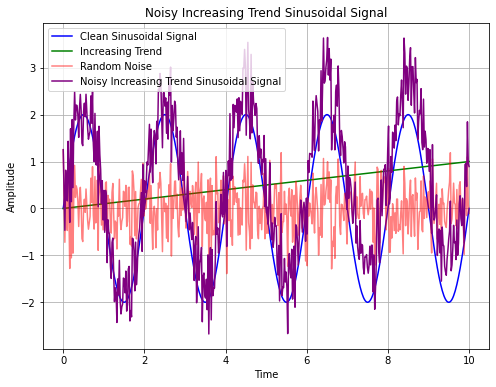

In [8]:


# Define parameters
t = np.linspace(0, 10, 500)  # Time values from 0 to 10
amplitude = 2.0  # Amplitude of the sinusoidal signal
frequency = 0.5  # Frequency of the sinusoidal signal (in Hz)
trend_slope = 0.1  # Slope of the increasing trend
noise_stddev = 0.5  # Standard deviation of the noise

# Generate the clean sinusoidal signal
sinusoid = amplitude * np.sin(2 * np.pi * frequency * t)

# Generate the increasing trend
trend = trend_slope * t

# Generate random noise
noise = np.random.normal(0, noise_stddev, t.shape)

# Combine the components to create the noisy increasing trend sinusoidal signal
signal = sinusoid + trend + noise

# Plot the signal components

plt.plot(t, sinusoid, label='Clean Sinusoidal Signal', color='blue')
plt.plot(t, trend, label='Increasing Trend', color='green')
plt.plot(t, noise, label='Random Noise', color='red', alpha=0.5)
plt.plot(t, signal, label='Noisy Increasing Trend Sinusoidal Signal', color='purple')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Noisy Increasing Trend Sinusoidal Signal')
plt.grid(True)
plt.show()

## Smoothning

In [9]:
from scipy import signal as sig

In [10]:
smooth_signal = sig.savgol_filter(signal,21,2)

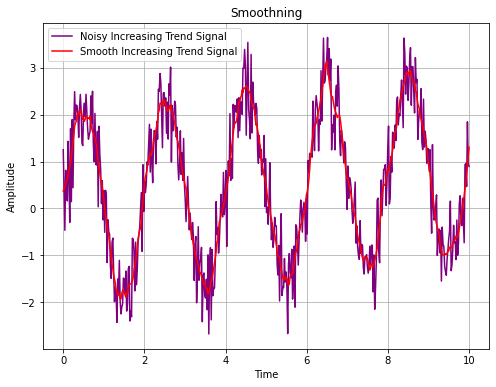

In [11]:
plt.title('Smoothning')
plt.plot(t,signal, color='purple',label='Noisy Increasing Trend Signal')
plt.plot(t,smooth_signal, color='red', label='Smooth Increasing Trend Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

## Detrending

In [12]:
detrend_smooth_signal = sig.detrend(smooth_signal)

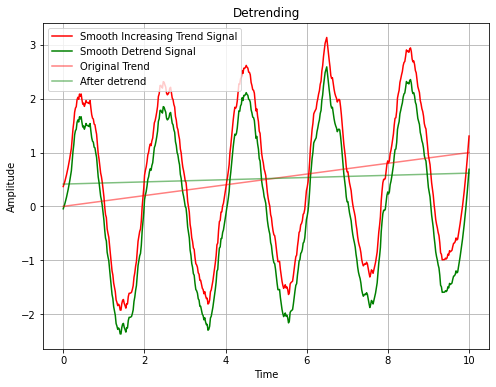

In [13]:
plt.plot(t,smooth_signal, color='red', label='Smooth Increasing Trend Signal')
plt.plot(t,detrend_smooth_signal, color='green', label='Smooth Detrend Signal')
plt.plot(t,trend, color='red', alpha=0.5, label='Original Trend')
plt.plot(t,smooth_signal - detrend_smooth_signal, color='green',alpha=0.5,label='After detrend')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Detrending')
plt.grid(True)
plt.legend()

## FFT

In [14]:
from scipy.fft import rfft, rfftfreq

In [15]:
n = len(detrend_smooth_signal)
T = 1

In [16]:
yf = rfft(detrend_smooth_signal)
xf = rfftfreq(n,T)

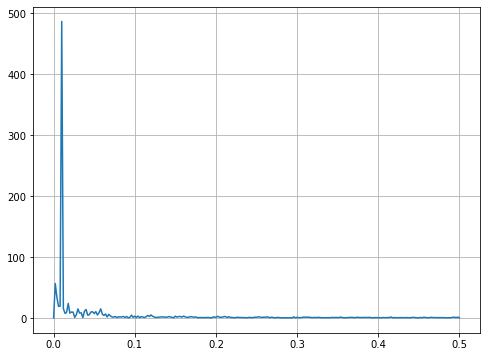

In [17]:
plt.plot(xf,np.abs(yf))
plt.grid(True)

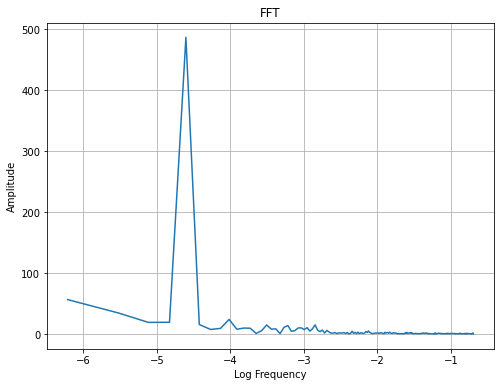

In [18]:
plt.plot(np.log(xf),np.abs(yf))
plt.xlabel('Log Frequency')
plt.ylabel('Amplitude')
plt.title('FFT')
plt.grid(True)

In [19]:
from matplotlib import cm

In [20]:
f, t, Sxx = sig.spectrogram(detrend_smooth_signal)

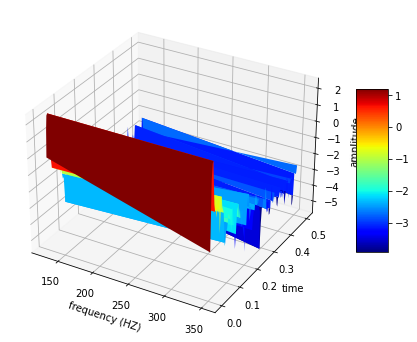

In [21]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(t[None,:],f[:,None],np.log10(Sxx),cmap='jet')
fig.colorbar(surf,shrink = 0.5,
             aspect = 5)
ax.set_xlabel('frequency (HZ)')
ax.set_ylabel('time')
ax.set_zlabel('amplitude')

plt.show()

## CWT

In [22]:
import pywt

In [23]:
# def autoscales(N, dt, dj, wf='morlet', p=6):
#     """
#     Compute scales for wavelet analysis using a logarithmic scale range.
    
#     Parameters:
#     N (int): Number of data points in the signal.
#     dt (float): Time interval between data points.
#     dj (float): Scale resolution parameter for the wavelet transform.
#     wf (str): Type of wavelet function (default is 'morlet').
#     p (int): Omega0 parameter for the Morlet wavelet (default is 6).
    
#     Returns:
#     scales (numpy.ndarray): Array of scales for wavelet transform.
#     """
#     # Define the range of scales (frequency range) of interest
#     min_scale = 2 * dt  # Minimum scale (2 * delta t)
#     max_scale = (N / 2) * dt  # Maximum scale (Nyquist frequency)

#     # Compute the number of scales based on the resolution parameter
#     num_scales = int(np.log2(max_scale / min_scale) / dj)

#     # Generate scales logarithmically between min_scale and max_scale
#     scales = min_scale * 2 ** (dj * np.arange(num_scales))

#     return scales
def autoscales(N, dt, dj, wf='morlet', p=6):
    """Compute scales as fractional power of two.

     :Parameters:
        N : integer
           number of data samples
        dt : float
           time step
        dj : float
           scale resolution (smaller values of dj give finer resolution)
        wf : string
           wavelet function ('morlet', 'paul', 'dog')
        p : float
           omega0 ('morlet') or order ('paul', 'dog')

     :Returns:
        scales : 1d numpy array
           scales
     """

    if wf == 'dog':
        s0 = (dt * sqrt(p + 0.5)) / np.pi
    elif wf == 'paul':
        s0 = (dt * ((2 * p) + 1)) / (2 * np.pi)
    elif wf == 'morlet':
        s0 = (dt * (p + np.sqrt(2 + p ** 2))) / (2 * np.pi)
    else:
        raise ValueError('wavelet function not available')

    #  See (9) and (10) at page 67.

    J = int(np.floor(dj ** -1 * np.log2((N * dt) / s0)))
    s = np.empty(J + 1)

    for i in range(s.shape[0]):
        s[i] = s0 * 2 ** (i * dj)

    return s

In [24]:
def scales_from_fourier(f, wf='morlet', p=6):
    """Compute scales from fourier period.

    :Parameters:
       f : list or 1d numpy array
          fourier wavelengths
       wf : string ('morlet', 'paul', 'dog')
          wavelet function
       p : float
          wavelet function parameter ('omega0' for morlet, 'm' for paul
          and dog)

    :Returns:
       scales
    """

    f_arr = np.asarray(f)

    if wf == 'dog':
        return (f_arr * np.sqrt(p + 0.5)) / (2 * np.pi)
    elif wf == 'paul':
        return (f_arr * ((2 * p) + 1)) / (4 * np.pi)
    elif wf == 'morlet':
        return (f_arr * (p + np.sqrt(2 + p ** 2))) / (4 * np.pi)
    else:
        raise ValueError('wavelet function not available')

In [25]:
widths = autoscales(len(detrend_smooth_signal),1,1)
# widths = scales_from_fourier(xf)
widths

array([  1.93602662,   3.87205324,   7.74410647,  15.48821295,
        30.97642589,  61.95285179, 123.90570358, 247.81140715,
       495.62281431])

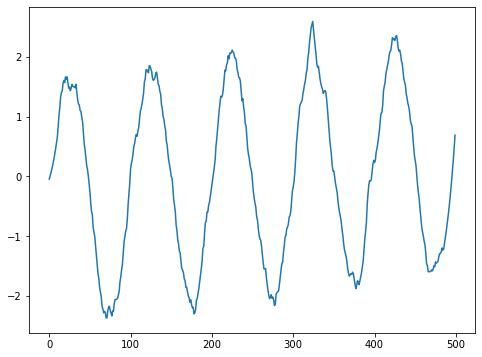

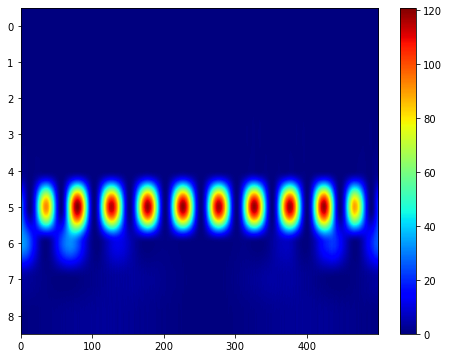

In [26]:
coefs, freqs = pywt.cwt(detrend_smooth_signal, widths,'morl')
# fig, ax = plt.subplots(1,2,figsize=(16, 6))
plt.plot(detrend_smooth_signal)
plt.show()
plt.imshow(
    np.abs(coefs)**2,
    cmap='jet',
    aspect="auto"
)
plt.colorbar()
# plt.suptitle('CWT analysis of preprocessed Signal')
# plt.tight_layout()
plt.show()

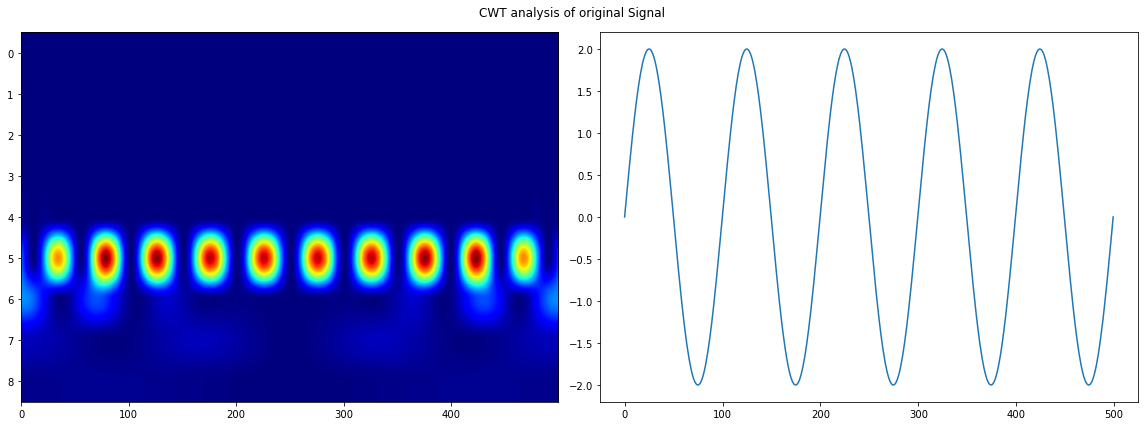

In [27]:
coefs, freqs = pywt.cwt(sinusoid, widths, "morl")
fig, ax = plt.subplots(1,2,figsize=(16, 6))
ax[1].plot(sinusoid)
ax[0].imshow(
    np.abs(coefs)**2,
    cmap='jet',
    aspect="auto",
)
plt.suptitle('CWT analysis of original Signal')

plt.tight_layout()
plt.show()

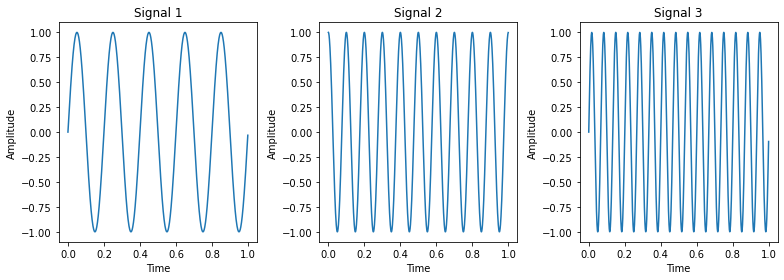

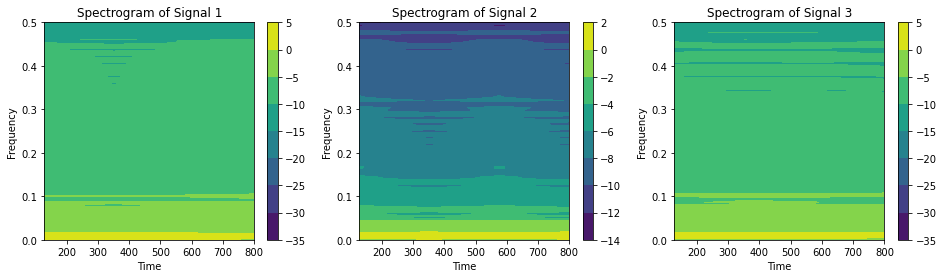

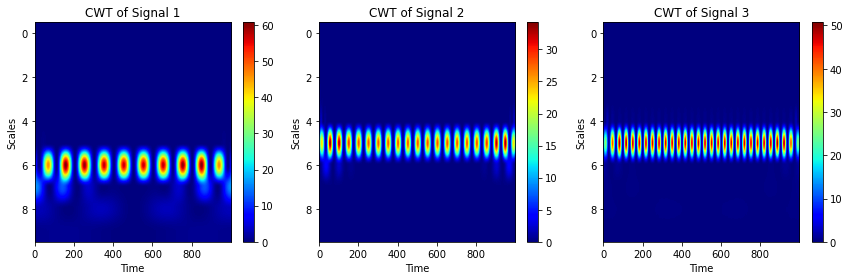

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy import signal
# Create different types of signals
t = np.linspace(0, 1, 1000, endpoint=False)
signal_1 = np.sin(2 * np.pi * 5 * t)
signal_2 = np.cos(2 * np.pi * 10 * t)
signal_3 = np.sin(2 * np.pi * 15 * t)

# Plot the generated signals
plt.figure(figsize=(11, 4))
plt.subplot(131)
plt.plot(t, signal_1)
plt.title('Signal 1')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.subplot(132)
plt.plot(t, signal_2)
plt.title('Signal 2')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.subplot(133)
plt.plot(t, signal_3)
plt.title('Signal 3')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.tight_layout()


freq1, time1, sxx1 = signal.spectrogram(signal_1)
freq2, time2, sxx2 = signal.spectrogram(signal_2)
freq3, time3, sxx3 = signal.spectrogram(signal_3)


# Apply Continuous Wavelet Transform
wavelet = 'morl'  # Complex Morlet wavelet
widths = autoscales(len(signal_1),1,1)
cwmatr_1, freq_1 = pywt.cwt(signal_1, widths, wavelet)
cwmatr_2, freq_2 = pywt.cwt(signal_2, widths, wavelet)
cwmatr_3, freq_3 = pywt.cwt(signal_3, widths, wavelet)

cwtmatr_1 = np.abs(cwmatr_1)**2
cwtmatr_2 = np.abs(cwmatr_2)**2
cwtmatr_3 = np.abs(cwmatr_3)**2

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.contourf(time1,freq1,np.log10(sxx1))
plt.title('Spectrogram of Signal 1')
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.colorbar()

plt.subplot(132)
plt.contourf(time2,freq2,np.log10(sxx2))
plt.title('Spectrogram of Signal 2')
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.colorbar()

plt.subplot(133)
plt.contourf(time3,freq3,np.log10(sxx3))
plt.title('Spectrogram of Signal 3')
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.colorbar()

# Plot the CWT of each signal
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(cwtmatr_1, cmap='jet', aspect='auto')
plt.title('CWT of Signal 1')
plt.ylabel('Scales')
plt.xlabel('Time')
plt.colorbar()

plt.subplot(132)
plt.imshow(cwtmatr_2,cmap='jet', aspect='auto')
plt.title('CWT of Signal 2')
plt.ylabel('Scales')
plt.xlabel('Time')
plt.colorbar()

plt.subplot(133)
plt.imshow(cwtmatr_3,cmap='jet', aspect='auto')
plt.title('CWT of Signal 3')
plt.ylabel('Scales')
plt.xlabel('Time')
plt.colorbar()

plt.tight_layout()
plt.show()

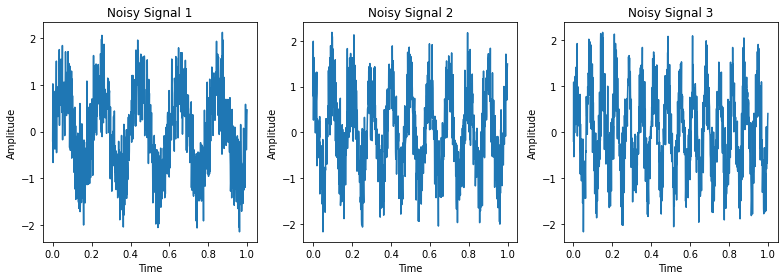

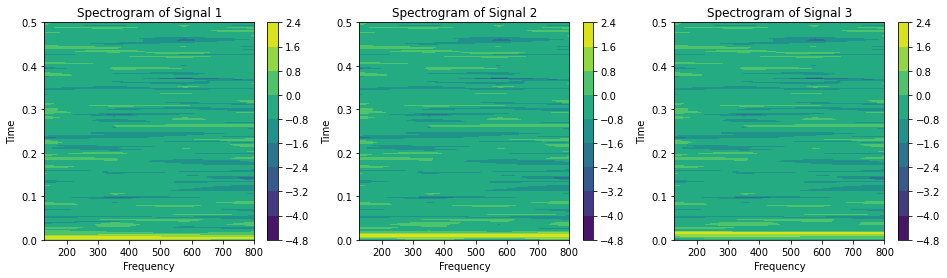

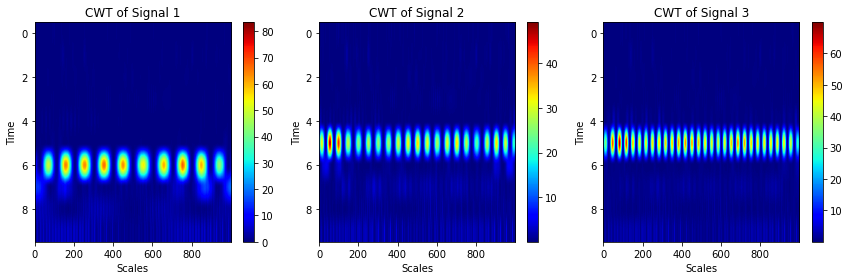

In [29]:
# Create different types of signals
t = np.linspace(0, 1, 1000, endpoint=False)
noise_stddev = 0.5  # Standard deviation of the noise
# Generate random noise
noise = np.random.normal(0, noise_stddev, t.shape)
ns_signal_1 = np.sin(2 * np.pi * 5 * t) + noise 
ns_signal_2 = np.cos(2 * np.pi * 10 * t) + noise
ns_signal_3 = np.sin(2 * np.pi * 15 * t) + noise

# Plot the generated signals
plt.figure(figsize=(11, 4))
plt.subplot(131)
plt.plot(t, ns_signal_1)
plt.title('Noisy Signal 1')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.subplot(132)
plt.plot(t, ns_signal_2)
plt.title('Noisy Signal 2')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.subplot(133)
plt.plot(t, ns_signal_3)
plt.title('Noisy Signal 3')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.tight_layout()


freq1, time1, sxx1 = signal.spectrogram(ns_signal_1)
freq2, time2, sxx2 = signal.spectrogram(ns_signal_2)
freq3, time3, sxx3 = signal.spectrogram(ns_signal_3)


# Apply Continuous Wavelet Transform
wavelet = 'morl'  # Complex Morlet wavelet
widths = autoscales(len(ns_signal_1),1,1)
cwmatr_1, freq_1 = pywt.cwt(ns_signal_1, widths, wavelet)
cwmatr_2, freq_2 = pywt.cwt(ns_signal_2, widths, wavelet)
cwmatr_3, freq_3 = pywt.cwt(ns_signal_3, widths, wavelet)

cwtmatr_1 = np.abs(cwmatr_1)**2
cwtmatr_2 = np.abs(cwmatr_2)**2
cwtmatr_3 = np.abs(cwmatr_3)**2

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.contourf(time1,freq1,np.log10(sxx1))
plt.title('Spectrogram of Signal 1')
plt.xlabel('Frequency')
plt.ylabel('Time')
plt.colorbar()

plt.subplot(132)
plt.contourf(time2,freq2,np.log10(sxx2))
plt.title('Spectrogram of Signal 2')
plt.xlabel('Frequency')
plt.ylabel('Time')
plt.colorbar()

plt.subplot(133)
plt.contourf(time3,freq3,np.log10(sxx3))
plt.title('Spectrogram of Signal 3')
plt.xlabel('Frequency')
plt.ylabel('Time')
plt.colorbar()

# Plot the CWT of each signal
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(cwtmatr_1, cmap='jet', aspect='auto')
plt.title('CWT of Signal 1')
plt.xlabel('Scales')
plt.ylabel('Time')
plt.colorbar()

plt.subplot(132)
plt.imshow(cwtmatr_2, cmap='jet', aspect='auto')
plt.title('CWT of Signal 2')
plt.xlabel('Scales')
plt.ylabel('Time')
plt.colorbar()

plt.subplot(133)
plt.imshow(cwtmatr_3, cmap='jet', aspect='auto')
plt.title('CWT of Signal 3')
plt.xlabel('Scales')
plt.ylabel('Time')
plt.colorbar()

plt.tight_layout()
plt.show()

In [30]:
fs = 1000

Sure, let's discuss the mathematical formulations for some common temporal and spectral features and how to interpret their results.

### Temporal Features:

1. **Mean (μ):**
   - **Mathematical Formulation:** $\mu = \frac{1}{N} \sum_{i=1}^{N} x_i$
   - **Interpretation:** Represents the average value of the signal. It provides information about the central tendency.

2. **Standard Deviation (σ):**
   - **Mathematical Formulation:** $\sigma = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2}$
   - **Interpretation:** Measures the spread or dispersion of the signal values around the mean. A higher standard deviation indicates greater variability.

3. **Skewness:**
   - **Mathematical Formulation:** $Skewness = \frac{\frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^3}{\left(\frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2\right)^{3/2}}$
   - **Interpretation:** Indicates the asymmetry of the distribution. Positive skewness implies a longer right tail, while negative skewness implies a longer left tail.

4. **Kurtosis:**
   - **Mathematical Formulation:** $Kurtosis = \frac{\frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^4}{\left(\frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2\right)^{2}} - 3$
   - **Interpretation:** Measures the tails and the peakedness of the distribution. Positive kurtosis indicates heavier tails and a sharper peak, while negative kurtosis indicates lighter tails and a flatter peak.

### Spectral Features:

1. **Max Frequency:**
   - **Mathematical Formulation:** $f_{\text{max}} = \text{argmax}(PSD(f))$
   - **Interpretation:** Identifies the frequency with the maximum power spectral density. It indicates the dominant frequency in the signal.

2. **Spectral Centroid:**
   - **Mathematical Formulation:** $f_c = \frac{\sum_{i=1}^{N} f_i \cdot \text{PSD}(f_i)}{\sum_{i=1}^{N} \text{PSD}(f_i)}$
   - **Interpretation:** Represents the "center of mass" of the power spectral density. It provides the average frequency of the signal.

3. **Spectral Spread:**
   - **Mathematical Formulation:** $f_{\text{spread}} = \sqrt{\frac{\sum_{i=1}^{N} (\text{PSD}(f_i) \cdot (f_i - f_c)^2)}{\sum_{i=1}^{N} \text{PSD}(f_i)}}$
   - **Interpretation:** Measures the spread or width of the power spectral density. It indicates how concentrated the energy is around the spectral centroid.

### Interpreting Results:

- **Temporal Features:**
  - Mean: A measure of central tendency.
  - Standard Deviation: Indicates the variability or spread of the signal values.
  - Skewness: Measures the asymmetry of the distribution.
  - Kurtosis: Indicates the tails and peakedness of the distribution.

- **Spectral Features:**
  - Max Frequency: Identifies the dominant frequency.
  - Spectral Centroid: Provides the average frequency of the signal.
  - Spectral Spread: Indicates how spread out the energy is in the frequency domain.

Interpretation depends on the context of your specific application. For instance, in signal processing, spectral centroid and spread are crucial for understanding the frequency distribution in audio signals. In finance, skewness and kurtosis may be used to analyze the distribution of returns. Always consider the characteristics of your data and the requirements of your analysis.

In [31]:
from scipy.stats import skew, kurtosis

# Function to extract temporal features
def temporal_features(signal, fs):
    mean_amp = np.mean(signal)
    std_dev = np.std(signal)
    skewness = skew(signal)
    kurt = kurtosis(signal)
    return mean_amp, std_dev, skewness, kurt


def spectral_features(freq, power_spectral_density):
    max_freq = freq[np.argmax(power_spectral_density)]
    total_power = np.sum(power_spectral_density)
    normalized_power = power_spectral_density / total_power
    spectral_centroid = np.sum( normalized_power.T@ freq)
    spectral_spread = np.sqrt(np.sum(normalized_power.T @ (freq - spectral_centroid)**2))
    return max_freq, spectral_centroid, spectral_spread



# Extract features for each signal
temporal_features_1 = temporal_features(ns_signal_1, fs)
temporal_features_2 = temporal_features(ns_signal_2, fs)
temporal_features_3 = temporal_features(ns_signal_3, fs)

spectral_features_1 = spectral_features(freq1, sxx1)
spectral_features_2 = spectral_features(freq2, sxx2)
spectral_features_3 = spectral_features(freq3, sxx3)

def round_features(value):
    return round(value, 5)

# Round off the values
temporal_features_1 = [round_features(value) for value in temporal_features_1]
temporal_features_2 = [round_features(value) for value in temporal_features_2]
temporal_features_3 = [round_features(value) for value in temporal_features_3]

spectral_features_1 = [round_features(value) for value in spectral_features_1]
spectral_features_2 = [round_features(value) for value in spectral_features_2]
spectral_features_3 = [round_features(value) for value in spectral_features_3]

# Print extracted features
print("Temporal Features:")
print("Signal 1 - Mean Amplitude: {}, Std Deviation: {}, Skewness: {}, Kurtosis: {}".format(*temporal_features_1))
print("Signal 2 - Mean Amplitude: {}, Std Deviation: {}, Skewness: {}, Kurtosis: {}".format(*temporal_features_2))
print("Signal 3 - Mean Amplitude: {}, Std Deviation: {}, Skewness: {}, Kurtosis: {}".format(*temporal_features_3))

print("\nSpectral Features:")
print("Signal 1 - Max Frequency: {}, Spectral Centroid: {}, Spectral Spread: {}".format(*spectral_features_1))
print("Signal 2 - Max Frequency: {}, Spectral Centroid: {}, Spectral Spread: {}".format(*spectral_features_2))
print("Signal 3 - Max Frequency: {}, Spectral Centroid: {}, Spectral Spread: {}".format(*spectral_features_3))

Temporal Features:
Signal 1 - Mean Amplitude: 0.00628, Std Deviation: 0.88311, Skewness: -0.03227, Kurtosis: -0.80265
Signal 2 - Mean Amplitude: 0.00628, Std Deviation: 0.88431, Skewness: 0.01805, Kurtosis: -0.67531
Signal 3 - Mean Amplitude: 0.00628, Std Deviation: 0.88524, Skewness: 0.03284, Kurtosis: -0.63866

Spectral Features:
Signal 1 - Max Frequency: 0.01953, Spectral Centroid: 0.08437, Spectral Spread: 0.14244
Signal 2 - Max Frequency: 0.04688, Spectral Centroid: 0.08765, Spectral Spread: 0.1404
Signal 3 - Max Frequency: 0.0625, Spectral Centroid: 0.09271, Spectral Spread: 0.13957


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


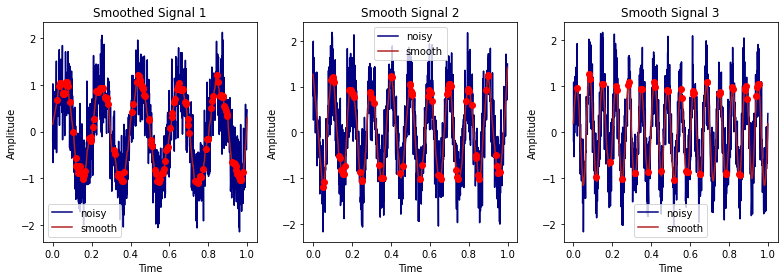

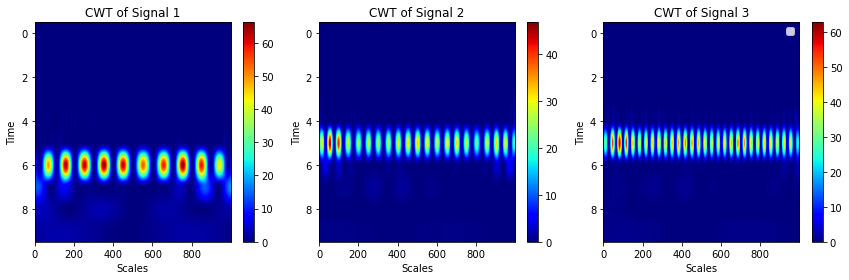

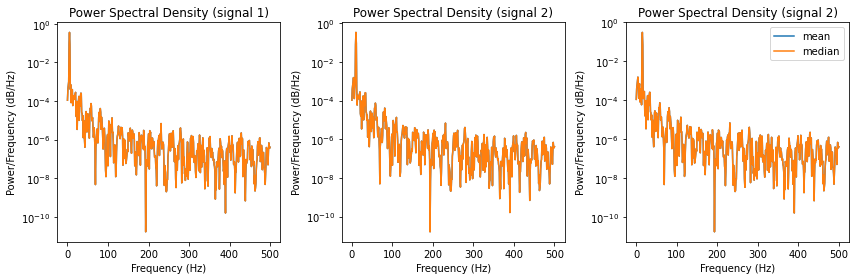

Temporal Features:
Signal 1 - Mean Amplitude: 0.006541, Std Deviation: 0.735755, Skewness: -0.051423, Kurtosis: -1.489058
Signal 2 - Mean Amplitude: 0.006178, Std Deviation: 0.731545, Skewness: 0.027142, Kurtosis: -1.428715
Signal 3 - Mean Amplitude: 0.006591, Std Deviation: 0.707493, Skewness: 0.012964, Kurtosis: -1.452061

Spectral Features:
Signal 1 - Max Frequency: 0.019531, Spectral Centroid: 0.084372, Spectral Spread: 0.142437
Signal 2 - Max Frequency: 0.046875, Spectral Centroid: 0.087653, Spectral Spread: 0.1404
Signal 3 - Max Frequency: 0.0625, Spectral Centroid: 0.092709, Spectral Spread: 0.139568

Vector Strength:
Vector Strength for Signal 1: 0.022433
Vector Strength for Signal 2: 0.072448
Vector Strength for Signal 3: 0.117618


In [32]:
from scipy.signal import find_peaks

sm_sig1 = signal.savgol_filter(ns_signal_1,41,2)
sm_sig2 = signal.savgol_filter(ns_signal_2,41,2)
sm_sig3 = signal.savgol_filter(ns_signal_3,41,2)

peaks_1,_ = find_peaks(sm_sig1)
peaks_2,_ = find_peaks(sm_sig2)
peaks_3,_ = find_peaks(sm_sig3)


# Plot the generated signals
plt.figure(figsize=(11, 4))
plt.subplot(131)
plt.plot(t,ns_signal_1,'navy',label='noisy')
plt.plot(t, sm_sig1,'firebrick',label='smooth')
plt.plot(t[peaks_1],sm_sig1[peaks_1],'ro')
plt.title('Smoothed Signal 1')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(132)
plt.plot(t,ns_signal_2,'navy',label='noisy')
plt.plot(t, sm_sig2,'firebrick',label='smooth')
plt.plot(t[peaks_2],sm_sig2[peaks_2],'ro')
plt.title('Smooth Signal 2')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(133)
plt.plot(t,ns_signal_3,'navy',label='noisy')
plt.plot(t, sm_sig3,'firebrick',label='smooth')
plt.plot(t[peaks_3],sm_sig3[peaks_3],'ro')
plt.title('Smooth Signal 3')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()

# peaks, _ = find_peaks(signal)
# plt.plot(t, signal)
# plt.plot(t[peaks], signal[peaks], 'ro')  # Mark peaks
# plt.title('Waveform Analysis with Peaks')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
# plt.show()

# freq1, time1, sxx1 = signal.spectrogram(sm_sig1)
# freq2, time2, sxx2 = signal.spectrogram(sm_sig2)
# freq3, time3, sxx3 = signal.spectrogram(sm_sig3)


# Apply Continuous Wavelet Transform
wavelet = 'morl'  # Morlet wavelet
widths = autoscales(len(sm_sig1),1,1)
cwmatr_1, freq_1 = pywt.cwt(sm_sig1, widths, wavelet)
cwmatr_2, freq_2 = pywt.cwt(sm_sig2, widths, wavelet)
cwmatr_3, freq_3 = pywt.cwt(sm_sig3, widths, wavelet)

cwtmatr_1 = np.abs(cwmatr_1)**2
cwtmatr_2 = np.abs(cwmatr_2)**2
cwtmatr_3 = np.abs(cwmatr_3)**2

# plt.figure(figsize=(16,4))
# plt.subplot(131)
# plt.contourf(time1,freq1,np.log10(sxx1))
# plt.title('Spectrogram of Signal 1')
# plt.xlabel('Frequency')
# plt.ylabel('Time')
# plt.colorbar()

# plt.subplot(132)
# plt.contourf(time2,freq2,np.log10(sxx2))
# plt.title('Spectrogram of Signal 2')
# plt.xlabel('Frequency')
# plt.ylabel('Time')
# plt.colorbar()

# plt.subplot(133)
# plt.contourf(time3,freq3,np.log10(sxx3))
# plt.title('Spectrogram of Signal 3')
# plt.xlabel('Frequency')
# plt.ylabel('Time')
# plt.colorbar()

# Plot the CWT of each signal
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(cwtmatr_1, cmap='jet', aspect='auto')
plt.title('CWT of Signal 1')
plt.xlabel('Scales')
plt.ylabel('Time')
plt.colorbar()

plt.subplot(132)
plt.imshow(cwtmatr_2, cmap='jet', aspect='auto')
plt.title('CWT of Signal 2')
plt.xlabel('Scales')
plt.ylabel('Time')
plt.colorbar()

plt.subplot(133)
plt.imshow(cwtmatr_3, cmap='jet', aspect='auto')
plt.title('CWT of Signal 3')
plt.xlabel('Scales')
plt.ylabel('Time')
plt.colorbar()

plt.legend()
plt.tight_layout()
plt.show()

from scipy.signal import welch
fs= 1000

freq_1, psd_1 = welch(sm_sig1, fs, nperseg=1024)
freq_2, psd_2 = welch(sm_sig2, fs, nperseg=1024)
freq_3, psd_3 = welch(sm_sig3, fs, nperseg=1024)

freq_1_med, psd_1_med = welch(sm_sig1, fs, nperseg=1024,average='median')
freq_2_med, psd_2_med = welch(sm_sig2, fs, nperseg=1024,average='median')
freq_3_med, psd_3_med = welch(sm_sig3, fs, nperseg=1024,average='median')


plt.figure(figsize=(12, 4))
# plt.suptitle('Power Spectral Density (PSD)')

plt.subplot(131)
plt.semilogy(freq_1, psd_1,label='mean')
plt.semilogy(freq_1_med, psd_1_med,label='median')
plt.title('Power Spectral Density (signal 1)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')

plt.subplot(132)
plt.semilogy(freq_2, psd_2,label='mean')
plt.semilogy(freq_2_med, psd_2_med,label='median')
plt.title('Power Spectral Density (signal 2)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')

plt.subplot(133)
plt.semilogy(freq_3, psd_3,label='mean')
plt.semilogy(freq_3_med, psd_3_med,label='median')
plt.title('Power Spectral Density (signal 2)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')

plt.legend()
plt.tight_layout()
plt.show()

# Extract features for each signal
temporal_features_1 = temporal_features(sm_sig1, fs)
temporal_features_2 = temporal_features(sm_sig2, fs)
temporal_features_3 = temporal_features(sm_sig3, fs)

spectral_features_1 = spectral_features(freq1, sxx1)
spectral_features_2 = spectral_features(freq2, sxx2)
spectral_features_3 = spectral_features(freq3, sxx3)

def round_features(value):
    return round(value, 6)

# Round off the values
temporal_features_1 = [round_features(value) for value in temporal_features_1]
temporal_features_2 = [round_features(value) for value in temporal_features_2]
temporal_features_3 = [round_features(value) for value in temporal_features_3]

spectral_features_1 = [round_features(value) for value in spectral_features_1]
spectral_features_2 = [round_features(value) for value in spectral_features_2]
spectral_features_3 = [round_features(value) for value in spectral_features_3]

# Print extracted features
print("Temporal Features:")
print("Signal 1 - Mean Amplitude: {}, Std Deviation: {}, Skewness: {}, Kurtosis: {}".format(*temporal_features_1))
print("Signal 2 - Mean Amplitude: {}, Std Deviation: {}, Skewness: {}, Kurtosis: {}".format(*temporal_features_2))
print("Signal 3 - Mean Amplitude: {}, Std Deviation: {}, Skewness: {}, Kurtosis: {}".format(*temporal_features_3))

print("\nSpectral Features:")
print("Signal 1 - Max Frequency: {}, Spectral Centroid: {}, Spectral Spread: {}".format(*spectral_features_1))
print("Signal 2 - Max Frequency: {}, Spectral Centroid: {}, Spectral Spread: {}".format(*spectral_features_2))
print("Signal 3 - Max Frequency: {}, Spectral Centroid: {}, Spectral Spread: {}".format(*spectral_features_3))

# Function to calculate vector strength
def calculate_vector_strength(peaks, t):
    # Calculate angular phases from peak times
    phases = 2 * np.pi * t[peaks]

    # Calculate mean resultant vector
    mean_resultant_vector = np.mean(np.exp(1j * phases))

    # Calculate vector strength
    vector_strength = np.abs(mean_resultant_vector)

    return vector_strength

# Calculate vector strength for each signal
vector_strength_1 = calculate_vector_strength(peaks_1, t)
vector_strength_2 = calculate_vector_strength(peaks_2, t)
vector_strength_3 = calculate_vector_strength(peaks_3, t)



# Print vector strength values
print("\nVector Strength:")
print("Vector Strength for Signal 1:", round_features(vector_strength_1))
print("Vector Strength for Signal 2:", round_features(vector_strength_2))
print("Vector Strength for Signal 3:", round_features(vector_strength_3))

# Show the plots
plt.show()

TypeError: plot_signal_with_peaks() takes 5 positional arguments but 6 were given

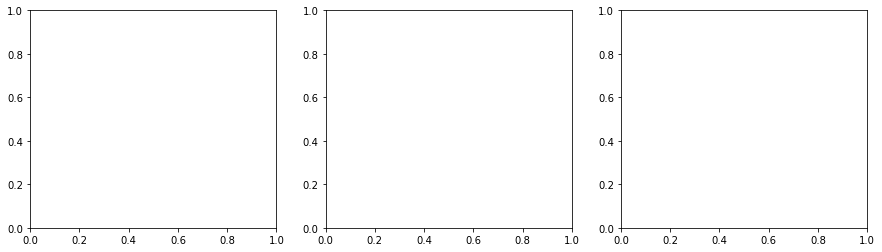

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy import signal as sig
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis
from tabulate import tabulate 

def autoscales(N, dt, dj, wf='morlet', p=6):
    """Compute scales as fractional power of two."""
    if wf == 'dog':
        s0 = (dt * np.sqrt(p + 0.5)) / np.pi
    elif wf == 'paul':
        s0 = (dt * ((2 * p) + 1)) / (2 * np.pi)
    elif wf == 'morlet':
        s0 = (dt * (p + np.sqrt(2 + p ** 2))) / (2 * np.pi)
    else:
        raise ValueError('wavelet function not available')

    J = int(np.floor(dj ** -1 * np.log2((N * dt) / s0)))
    s = np.empty(J + 1)

    for i in range(s.shape[0]):
        s[i] = s0 * 2 ** (i * dj)

    return s

def smooth_and_find_peaks(signal):
    smoothed_signal = sig.savgol_filter(signal, 41, 2)
    peaks, _ = find_peaks(smoothed_signal)
    return smoothed_signal, peaks

def plot_signal_with_peaks(t, ns_signal, sm_signal, peaks, title):
    plt.plot(t, ns_signal, 'navy', label='noisy')
    plt.plot(t, sm_signal, 'firebrick', label='smooth')
    plt.plot(t[peaks], sm_signal[peaks], 'ro')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()

def plot_cwt_and_spectrogram(signal, title):
    # Spectrogram
    freq, time, sxx = sig.spectrogram(signal)
    plt.figure(figsize=(6, 4))
    plt.contourf(time, freq, np.log10(sxx))
    plt.title(f'Spectrogram of {title}')
    plt.ylabel('Frequency')
    plt.xlabel('Time')
    plt.colorbar()

    # Continuous Wavelet Transform
    wavelet = 'morl'  # Complex Morlet wavelet
    widths = autoscales(len(signal), 1, 1)
    cwmatr, freq_cwt = pywt.cwt(signal, widths, wavelet)
    cwtmatr = np.abs(cwmatr)**2

    plt.figure(figsize=(6, 4))
    plt.imshow(cwtmatr, cmap='jet', aspect='auto')
    plt.title(f'CWT of {title}')
    plt.ylabel('Scales')
    plt.xlabel('Time')
    plt.colorbar()

def calculate_power_density_spectrum(signal, fs=1000):
    freq, psd = sig.welch(signal, fs, nperseg=1024)
    return freq, psd

def calculate_temporal_features(signal, fs):
    mean_amp = np.mean(signal)
    std_dev = np.std(signal)
    skewness = skew(signal)
    kurt = kurtosis(signal)
    return mean_amp, std_dev, skewness, kurt


def calculate_spectral_features(freq, power_spectral_density):
    max_freq = freq[np.argmax(power_spectral_density)]
    total_power = np.sum(power_spectral_density)
    normalized_power = power_spectral_density / total_power
    spectral_centroid = np.sum( normalized_power.T@ freq)
    spectral_spread = np.sqrt(np.sum(normalized_power.T @ (freq - spectral_centroid)**2))
    return max_freq, spectral_centroid, spectral_spread

def calculate_vector_strength(peaks, t):
    # Calculate angular phases from peak times
    phases = 2 * np.pi * t[peaks]

    # Calculate mean resultant vector
    mean_resultant_vector = np.mean(np.exp(1j * phases))

    # Calculate vector strength
    vector_strength = np.abs(mean_resultant_vector)

    return vector_strength

# def process_and_analyze_signals(ns_signals, t, fs=1000):
#     for i, ns_signal in enumerate(ns_signals, start=1):
#         sm_signal, peaks = smooth_and_find_peaks(ns_signal)

#         # Plot the signals with detected peaks
#         plt.figure(figsize=(11, 4))
#         plt.subplot(1, 3, i)
#         plot_signal_with_peaks(t, ns_signal, sm_signal, peaks, f'Smoothed Signal {i}')

#         # Plot CWT and Spectrogram
#         plot_cwt_and_spectrogram(sm_signal, f'Signal {i}')

#         # Calculate and plot Power Density Spectrum
#         freq_psd, psd = calculate_power_density_spectrum(sm_signal, fs)
#         plt.figure(figsize=(6, 4))
#         plt.semilogy(freq_psd, psd)
#         plt.title(f'Power Spectral Density (Signal {i})')
#         plt.xlabel('Frequency (Hz)')
#         plt.ylabel('Power/Frequency (dB/Hz)')
        
#         plt.tight_layout()
#         plt.show()
#         # Calculate and print Temporal Features
#         temporal_features = calculate_temporal_features(sm_signal, fs)
#         print(f'\nTemporal Features for Signal {i}:')
#         print(f'Mean Amplitude: {temporal_features[0]}, Std Deviation: {temporal_features[1]},'
#               f' Skewness: {temporal_features[2]}, Kurtosis: {temporal_features[3]}')

#         # Calculate and print Spectral Features
#         spectral_features = calculate_spectral_features(freq_psd, psd)
#         print(f'\nSpectral Features for Signal {i}:')
#         print(f'Max Frequency: {spectral_features[0]}, Spectral Centroid: {spectral_features[1]},'
#               f' Spectral Spread: {spectral_features[2]}')
        
#         # Calculate and print Vector Strength
#         vector_strength = calculate_vector_strength(peaks, t)
#         print(f'\nVector Strength for Signal {i}: {vector_strength}')
def process_and_analyze_signals(ns_signals, t, fs=1000):
    headers = ["Signal", "Mean Amplitude", "Std Deviation", "Skewness", "Kurtosis", 
               "Max Frequency", "Spectral Centroid", "Spectral Spread", "Vector Strength"]

    data = []
    
    for i, ns_signal in enumerate(ns_signals, start=1):
        sm_signal, peaks = smooth_and_find_peaks(ns_signal)

        # Plot the signals with detected peaks
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))
        plot_signal_with_peaks(axs[0], t, ns_signal, sm_signal, peaks, f'Smoothed Signal {i}')
        plot_cwt_and_spectrogram(axs[1], axs[2], sm_signal, f'Signal {i}')

        # Calculate and plot Power Density Spectrum
        freq_psd, psd = calculate_power_density_spectrum(sm_signal, fs)
        plt.figure(figsize=(6, 4))
        plt.semilogy(freq_psd, psd)
        plt.title(f'Power Spectral Density (Signal {i})')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power/Frequency (dB/Hz)')

        # Calculate Temporal Features
        temporal_features = calculate_temporal_features(sm_signal, fs)

        # Calculate Spectral Features
        spectral_features = calculate_spectral_features(freq_psd, psd)

        # Calculate Vector Strength
        vector_strength = calculate_vector_strength(peaks, t)

        data.append([f'Signal {i}'] + list(temporal_features) + list(spectral_features) + [vector_strength])
        
    plt.tight_layout()
    plt.show()

    # Print the results in a table
    print(tabulate(data, headers=headers, tablefmt="pretty"))
# Example usage:
# Assuming t, signal_1, signal_2, signal_3 are defined
# Create different types of signals
t = np.linspace(0, 1, 1000, endpoint=False)
noise_stddev = 0.5  # Standard deviation of the noise
# Generate random noise
noise = np.random.normal(0, noise_stddev, t.shape)
ns_signal_1 = np.sin(2 * np.pi * 5 * t) + noise 
ns_signal_2 = np.cos(2 * np.pi * 10 * t) + noise
ns_signal_3 = np.sin(2 * np.pi * 15 * t) + noise
process_and_analyze_signals([ns_signal_1, ns_signal_2, ns_signal_3], t)


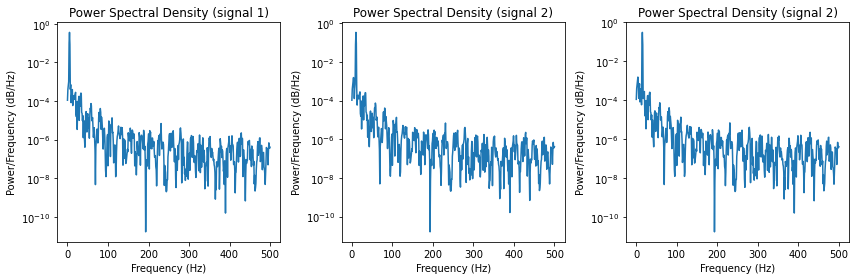

In [34]:
from scipy.signal import welch
fs= 1000

freq_1, psd_1 = welch(sm_sig1, fs, nperseg=1024)
freq_2, psd_2 = welch(sm_sig2, fs, nperseg=1024)
freq_3, psd_3 = welch(sm_sig3, fs, nperseg=1024)

plt.figure(figsize=(12, 4))
# plt.suptitle('Power Spectral Density (PSD)')

plt.subplot(131)
plt.semilogy(freq_1, psd_1)
plt.title('Power Spectral Density (signal 1)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')

plt.subplot(132)
plt.semilogy(freq_2, psd_2)
plt.title('Power Spectral Density (signal 2)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')

plt.subplot(133)
plt.semilogy(freq_3, psd_3)
plt.title('Power Spectral Density (signal 2)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')

plt.tight_layout()
plt.show()

In [ ]:
# 3D Plotting - Surface Plot for Scalogram
fig = plt.figure(figsize=(15, 6))

# Signal 1
ax1 = fig.add_subplot(131, projection='3d')
X, Y = np.meshgrid(np.arange(cwtmatr_1.shape[1]), np.arange(cwtmatr_1.shape[0]))
sur1 = ax1.plot_surface(X, Y, cwtmatr_1, cmap='jet',alpha= 0.8)
ax1.set_title('Scalogram: Signal 1')
ax1.set_xlabel('Time')
ax1.set_ylabel('frequency')
ax1.set_zlabel('Intensity')
plt.colorbar(sur1,shrink=0.5)
# Signal 2
ax2 = fig.add_subplot(132, projection='3d')
X, Y = np.meshgrid(np.arange(cwtmatr_2.shape[1]), np.arange(cwtmatr_2.shape[0]))
sur2= ax2.plot_surface(X, Y, cwtmatr_2, cmap='jet',alpha= 0.8)
ax2.set_title('Scalogram: Signal 2')
ax2.set_xlabel('Time')
ax2.set_ylabel('frequency')
ax2.set_zlabel('Intensity')
plt.colorbar(sur2,shrink=0.5)
# Signal 3
ax3 = fig.add_subplot(133, projection='3d')
X, Y = np.meshgrid(np.arange(cwtmatr_3.shape[1]), np.arange(cwtmatr_3.shape[0]))
sur3 = ax3.plot_surface(X, Y, cwtmatr_3, cmap='jet',alpha= 0.8)
ax3.set_title('Scalogram: Signal 3')
ax3.set_xlabel('Time')
ax3.set_ylabel('frequency')
ax3.set_zlabel('Intensity')
plt.colorbar(sur3,shrink=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# 3D Plotting - Surface Plot for Scalogram
fig = plt.figure(figsize=(15, 6))

# Signal 1
ax1 = fig.add_subplot(131, projection='3d')
X, Y = np.meshgrid(time1, freq1)
ax1.plot_surface(X, Y, np.log10(sxx1), cmap='jet')
ax1.set_title('Spectrogram: Signal 1')
ax1.set_xlabel('Time')
ax1.set_ylabel('frequency')
ax1.set_zlabel('Intensity')
# Signal 2
ax2 = fig.add_subplot(132, projection='3d')
X, Y = np.meshgrid(time2, freq2)
ax2.plot_surface(X, Y, np.log10(sxx2), cmap='jet')
ax2.set_title('Spectrogram: Signal 2')
ax2.set_xlabel('Time')
ax2.set_ylabel('frequency')
ax2.set_zlabel('Intensity')
# Signal 3
ax3 = fig.add_subplot(133, projection='3d')
X, Y = np.meshgrid(time3, freq3)
ax3.plot_surface(X, Y, np.log10(sxx3), cmap='jet')
ax3.set_title('Spectrogram: Signal 3')
ax3.set_xlabel('Time')
ax3.set_ylabel('frequency')
ax3.set_zlabel('Intensity')
plt.tight_layout()
plt.show()

In [ ]:

# Creating the combined signal
combined_signal = sm_sig1 + sm_sig2 + sm_sig3
plt.plot(t,combined_signal)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Combined Signal')
plt.show()
# Spectrogram
frequencies, times, spectrogram = signal.spectrogram(combined_signal, fs=1000)
plt.contourf(times, frequencies, 10 * np.log10(spectrogram))
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time')
plt.title('Spectrogram')
plt.colorbar()
plt.show()

# Scalogram
widths = autoscales(len(combined_signal),1,1)
cwtmatr = signal.cwt(combined_signal, signal.ricker, widths)
plt.imshow(np.abs(cwtmatr)**2, cmap='jet', aspect='auto')  # PRGn is the colormap
plt.ylabel('Scales')
plt.xlabel('Time')
plt.title('Scalogram')
plt.colorbar()
plt.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# # Plotting Spectrogram in 3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(times, frequencies, 10*np.log10(spectrogram), cmap='viridis')
# ax.set_xlabel('Time')
# ax.set_ylabel('Frequency (Hz)')
# ax.set_zlabel('Amplitude (dB)')
# ax.set_title('Spectrogram in 3D')
# plt.show()

# Plotting Scalogram in 3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(np.arange(cwtmatr.shape[1]),np.arange(cwtmatr.shape[0]))
sur = ax.plot_surface(X, Y, np.abs(cwtmatr)**2, cmap='jet')
ax.set_xlabel('Time')
ax.set_ylabel('frequency')
ax.set_zlabel('Amplitude')
ax.set_title('Scalogram in 3D')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(sur,shrink=0.5)
plt.show()


In [53]:
!pip install prettytable

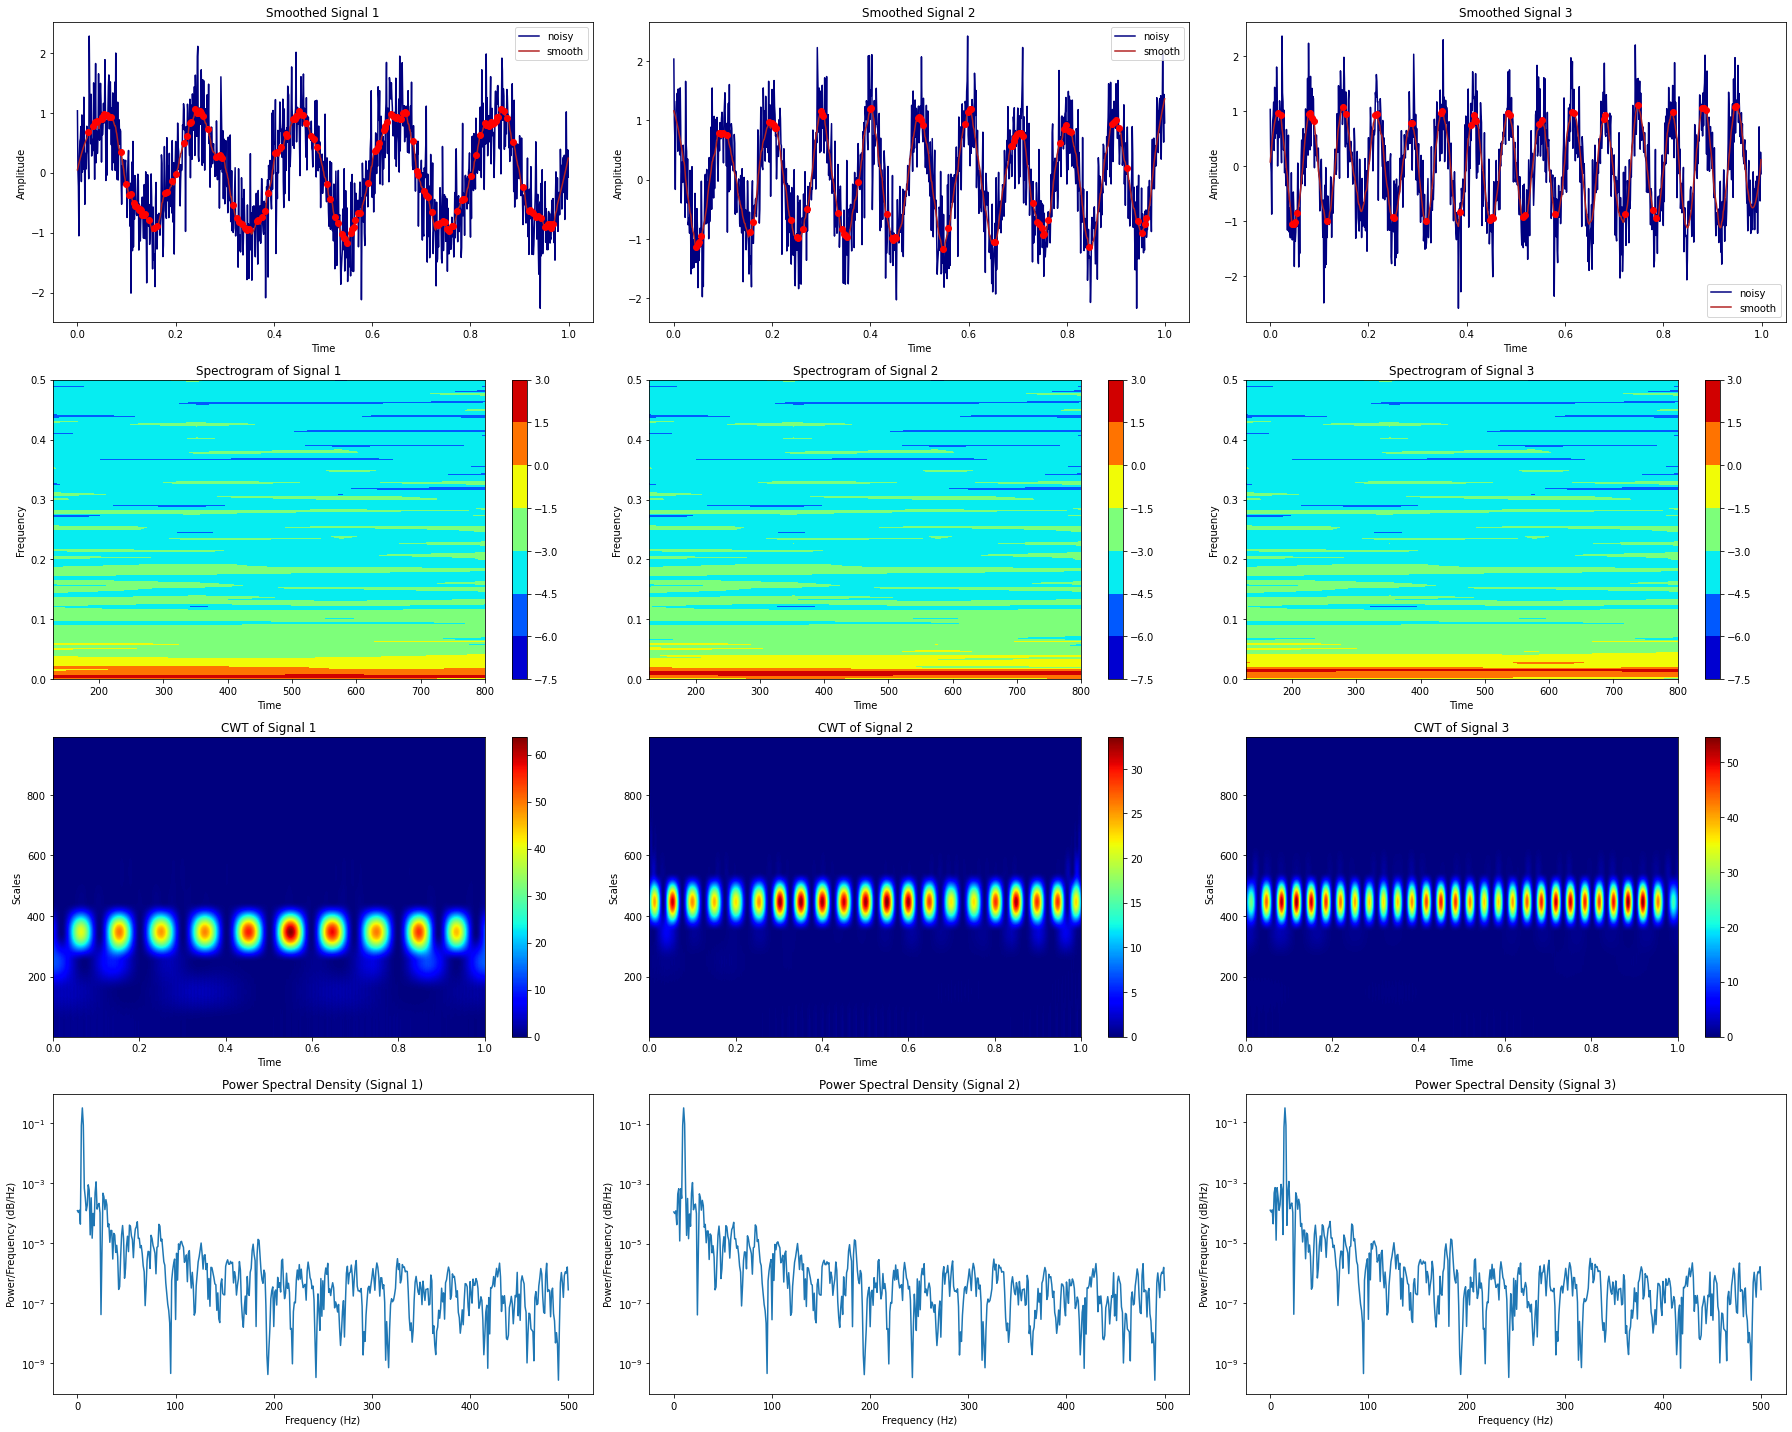

Temporal Features:
+----------+----------------+---------------+-----------+-----------+
|  Signal  | Mean Amplitude | Std Deviation |  Skewness |  Kurtosis |
+----------+----------------+---------------+-----------+-----------+
| Signal 1 |    -0.00098    |    0.68426    | -0.004773 | -1.469861 |
| Signal 2 |   -0.001344    |    0.710368   |  0.004109 |  -1.39539 |
| Signal 3 |   -0.000931    |    0.691451   | -0.016507 | -1.451119 |
+----------+----------------+---------------+-----------+-----------+

Spectral Features:
+----------+---------------+-------------------+-----------------+
|  Signal  | Max Frequency | Spectral Centroid | Spectral Spread |
+----------+---------------+-------------------+-----------------+
| Signal 1 |      5.0      |      5.406111     |     6.916197    |
| Signal 2 |      10.0     |      10.29265     |     6.382895    |
| Signal 3 |      15.0     |      15.24268     |     6.687719    |
+----------+---------------+-------------------+-----------------+

V

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy import signal as sig
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis
import pandas as pd
from prettytable import PrettyTable

def autoscales(N, dt, dj, wf='morlet', p=6):
    """Compute scales as fractional power of two."""
    if wf == 'dog':
        s0 = (dt * np.sqrt(p + 0.5)) / np.pi
    elif wf == 'paul':
        s0 = (dt * ((2 * p) + 1)) / (2 * np.pi)
    elif wf == 'morlet':
        s0 = (dt * (p + np.sqrt(2 + p ** 2))) / (2 * np.pi)
    else:
        raise ValueError('wavelet function not available')

    J = int(np.floor(dj ** -1 * np.log2((N * dt) / s0)))
    s = np.empty(J + 1)

    for i in range(s.shape[0]):
        s[i] = s0 * 2 ** (i * dj)

    return s

def smooth_and_find_peaks(signal):
    smoothed_signal = sig.savgol_filter(signal, 41, 2)
    peaks, _ = find_peaks(smoothed_signal)
    return smoothed_signal, peaks

def plot_signal_with_peaks(ax, t, ns_signal, sm_signal, peaks, title):
    ax.plot(t, ns_signal, 'navy', label='noisy')
    ax.plot(t, sm_signal, 'firebrick', label='smooth')
    ax.plot(t[peaks], sm_signal[peaks], 'ro')
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.legend()

def plot_spectrogram(ax, signal, title):
    # Spectrogram
    freq, time, sxx = sig.spectrogram(signal)
    plot = ax.contourf(time, freq, np.log10(sxx), cmap='jet', aspect='auto')
    ax.set_title(f'Spectrogram of {title}')
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Time')
    plt.colorbar(plot, ax=ax)

def plot_cwt(ax,signal,title):
    # Continuous Wavelet Transform
    wavelet = 'morl'  # Complex Morlet wavelet
    widths = autoscales(len(signal), 1, 1)
    cwmatr, freq_cwt = pywt.cwt(signal, widths, wavelet)
    cwtmatr = np.abs(cwmatr)**2
    plot = ax.imshow(cwtmatr, cmap='jet', aspect='auto', extent=[0, 1, min(widths), max(widths)])
    ax.set_title(f'CWT of {title}')
    ax.set_ylabel('Scales')
    ax.set_xlabel('Time')
    plt.colorbar(plot, ax=ax)

def calculate_power_density_spectrum(signal, fs=1000):
    freq, psd = sig.welch(signal, fs, nperseg=1024)
    return freq, psd

def calculate_temporal_features(signal, fs):
    mean_amp = np.mean(signal)
    std_dev = np.std(signal)
    skewness = skew(signal)
    kurt = kurtosis(signal)
    return mean_amp, std_dev, skewness, kurt

def calculate_spectral_features(freq, power_spectral_density):
    max_freq = freq[np.argmax(power_spectral_density)]
    total_power = np.sum(power_spectral_density)
    normalized_power = power_spectral_density / total_power
    spectral_centroid = np.sum(normalized_power * freq)
    spectral_spread = np.sqrt(np.sum(normalized_power * (freq - spectral_centroid)**2))
    return max_freq, spectral_centroid, spectral_spread

def calculate_vector_strength(peaks, t):
    # Calculate angular phases from peak times
    phases = 2 * np.pi * t[peaks]

    # Calculate mean resultant vector
    mean_resultant_vector = np.mean(np.exp(1j * phases))

    # Calculate vector strength
    vector_strength = np.abs(mean_resultant_vector)

    return vector_strength

def analyze_and_plot_signals(ns_signals, t, fs=1000):
    num_signals = len(ns_signals)

    # Create subplots
    fig, axs = plt.subplots(4, num_signals, figsize=(25, 20))
    axs = axs.flatten()

    # Create tables for numerical values
    columns_temporal = ['Signal', 'Mean Amplitude', 'Std Deviation', 'Skewness', 'Kurtosis']
    columns_spectral = ['Signal', 'Max Frequency', 'Spectral Centroid', 'Spectral Spread']
    columns_vector_strength = ['Signal', 'Vector Strength']

    table_temporal = PrettyTable(columns_temporal)
    table_spectral = PrettyTable(columns_spectral)
    table_vector_strength = PrettyTable(columns_vector_strength)


    for i, ns_signal in enumerate(ns_signals, start=1):
        sm_signal, peaks = smooth_and_find_peaks(ns_signal)

        # Plot the signals with detected peaks
        plot_signal_with_peaks(axs[i - 1], t, ns_signal, sm_signal, peaks, f'Smoothed Signal {i}')

        # Plot CWT and Spectrogram
        plot_spectrogram(axs[i + num_signals - 1], sm_signal, f'Signal {i}')
        plot_cwt(axs[i + 2 * num_signals - 1], sm_signal, f'Signal {i}')
        # Calculate and plot Power Density Spectrum
        freq_psd, psd = calculate_power_density_spectrum(sm_signal, fs)
        axs[i + 3 * num_signals - 1].semilogy(freq_psd, psd)
        axs[i + 3 * num_signals - 1].set_title(f'Power Spectral Density (Signal {i})')
        axs[i + 3 * num_signals - 1].set_xlabel('Frequency (Hz)')
        axs[i + 3 * num_signals - 1].set_ylabel('Power/Frequency (dB/Hz)')

        # Calculate and print Temporal Features
        temporal_features = calculate_temporal_features(sm_signal, fs)
        temporal_features = [round(value, 6) for value in temporal_features]

        # Calculate and print Spectral Features
        spectral_features = calculate_spectral_features(freq_psd, psd)
        spectral_features = [round(value, 6) for value in spectral_features]

        # Calculate and print Vector Strength
        vector_strength = calculate_vector_strength(peaks, t)
        vector_strength = round(vector_strength, 6)
        
        # Add data to PrettyTable
        # Add data to PrettyTables
        table_temporal.add_row([f'Signal {i}'] + temporal_features)
        table_spectral.add_row([f'Signal {i}'] + spectral_features)
        table_vector_strength.add_row([f'Signal {i}', vector_strength])
        
    plt.tight_layout()
    plt.show()
    
    # Print PrettyTables
    print("Temporal Features:")
    print(table_temporal)

    print("\nSpectral Features:")
    print(table_spectral)

    print("\nVector Strength:")
    print(table_vector_strength)

   

# Example usage:
# Assuming t, ns_signal_1, ns_signal_2, ns_signal_3 are defined
# Create different types of signals
t = np.linspace(0, 1, 1000, endpoint=False)
noise_stddev = 0.5  # Standard deviation of the noise
# Generate random noise
noise = np.random.normal(0, noise_stddev, t.shape)
ns_signal_1 = np.sin(2 * np.pi * 5 * t) + noise 
ns_signal_2 = np.cos(2 * np.pi * 10 * t) + noise
ns_signal_3 = np.sin(2 * np.pi * 15 * t) + noise

analyze_and_plot_signals([ns_signal_1, ns_signal_2, ns_signal_3], t)



Signal 1
 


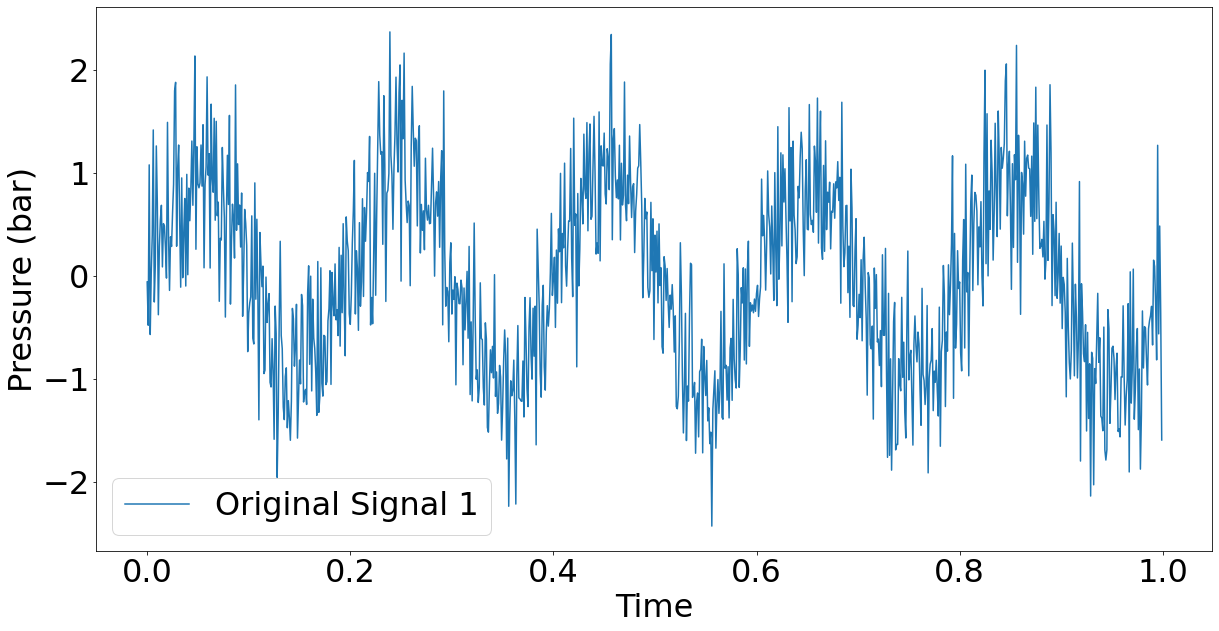

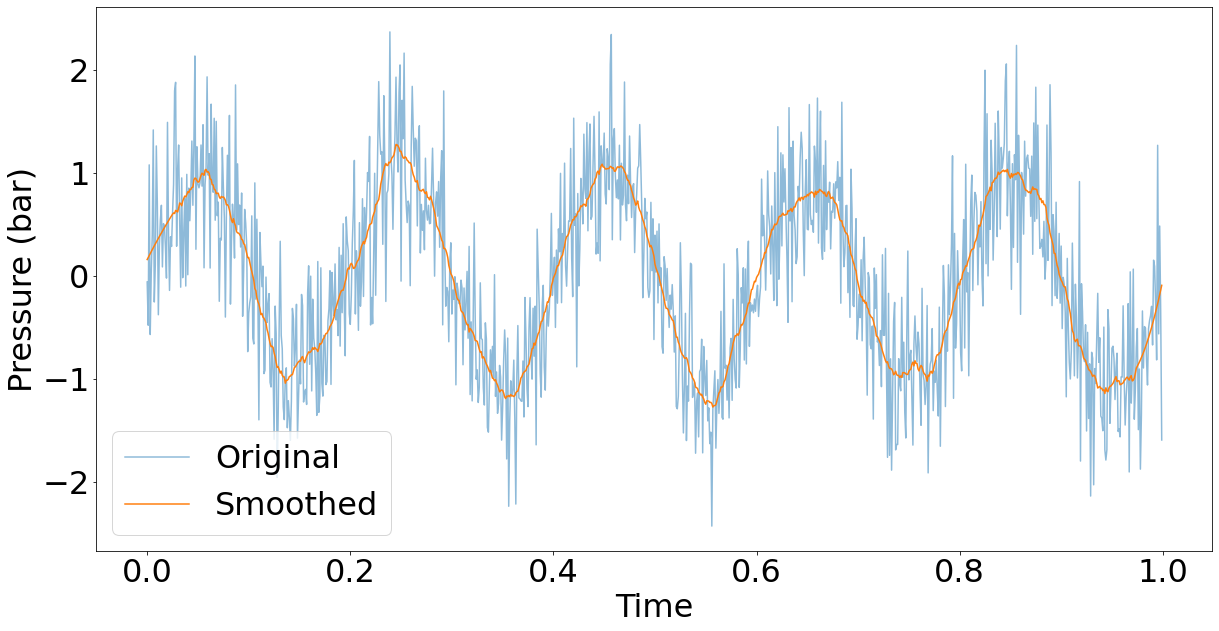

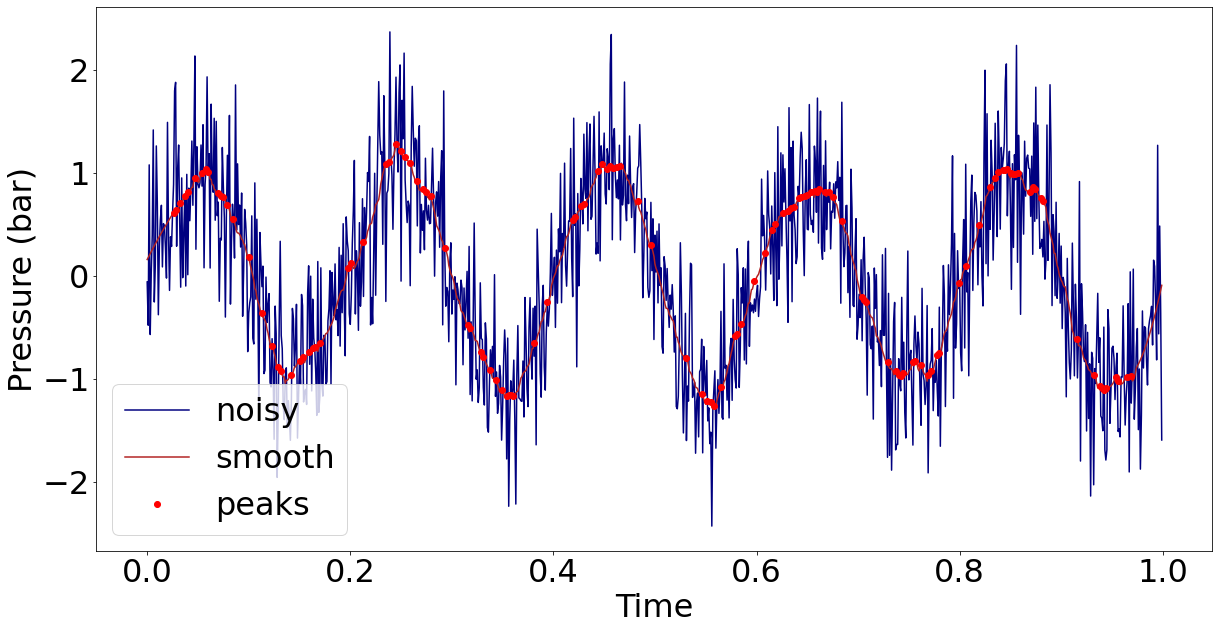

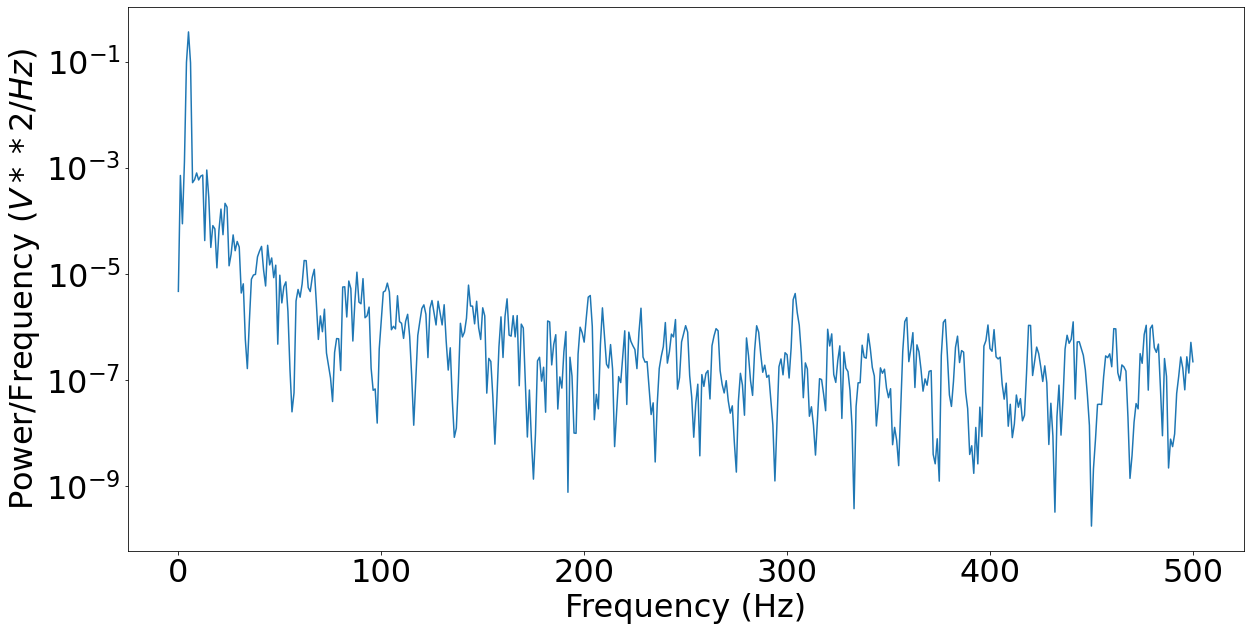

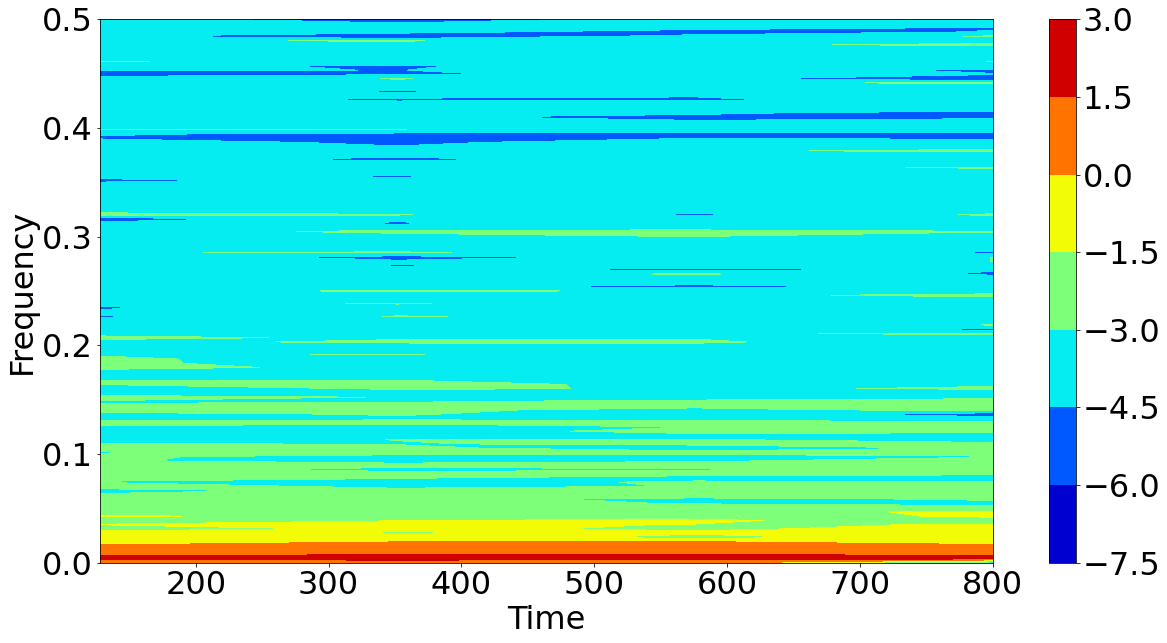

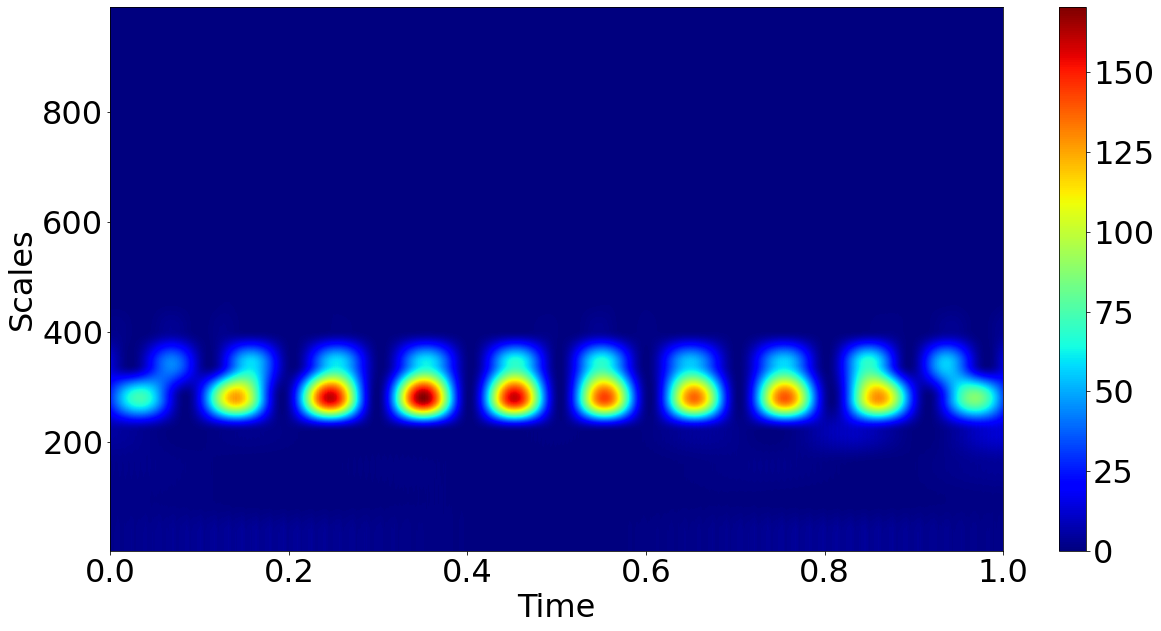

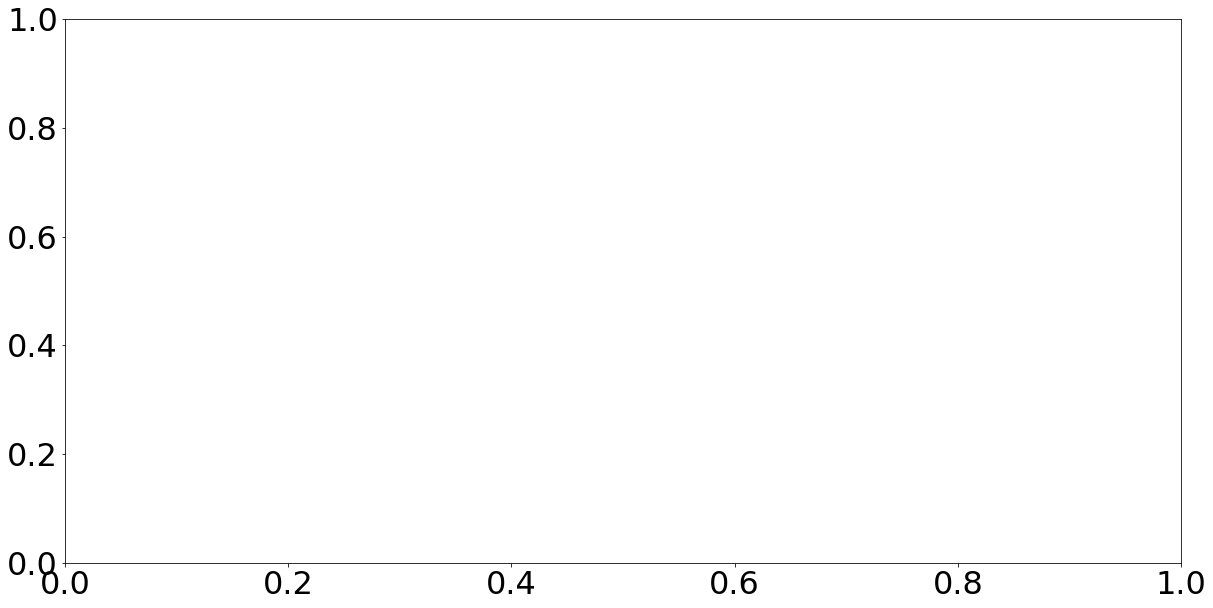

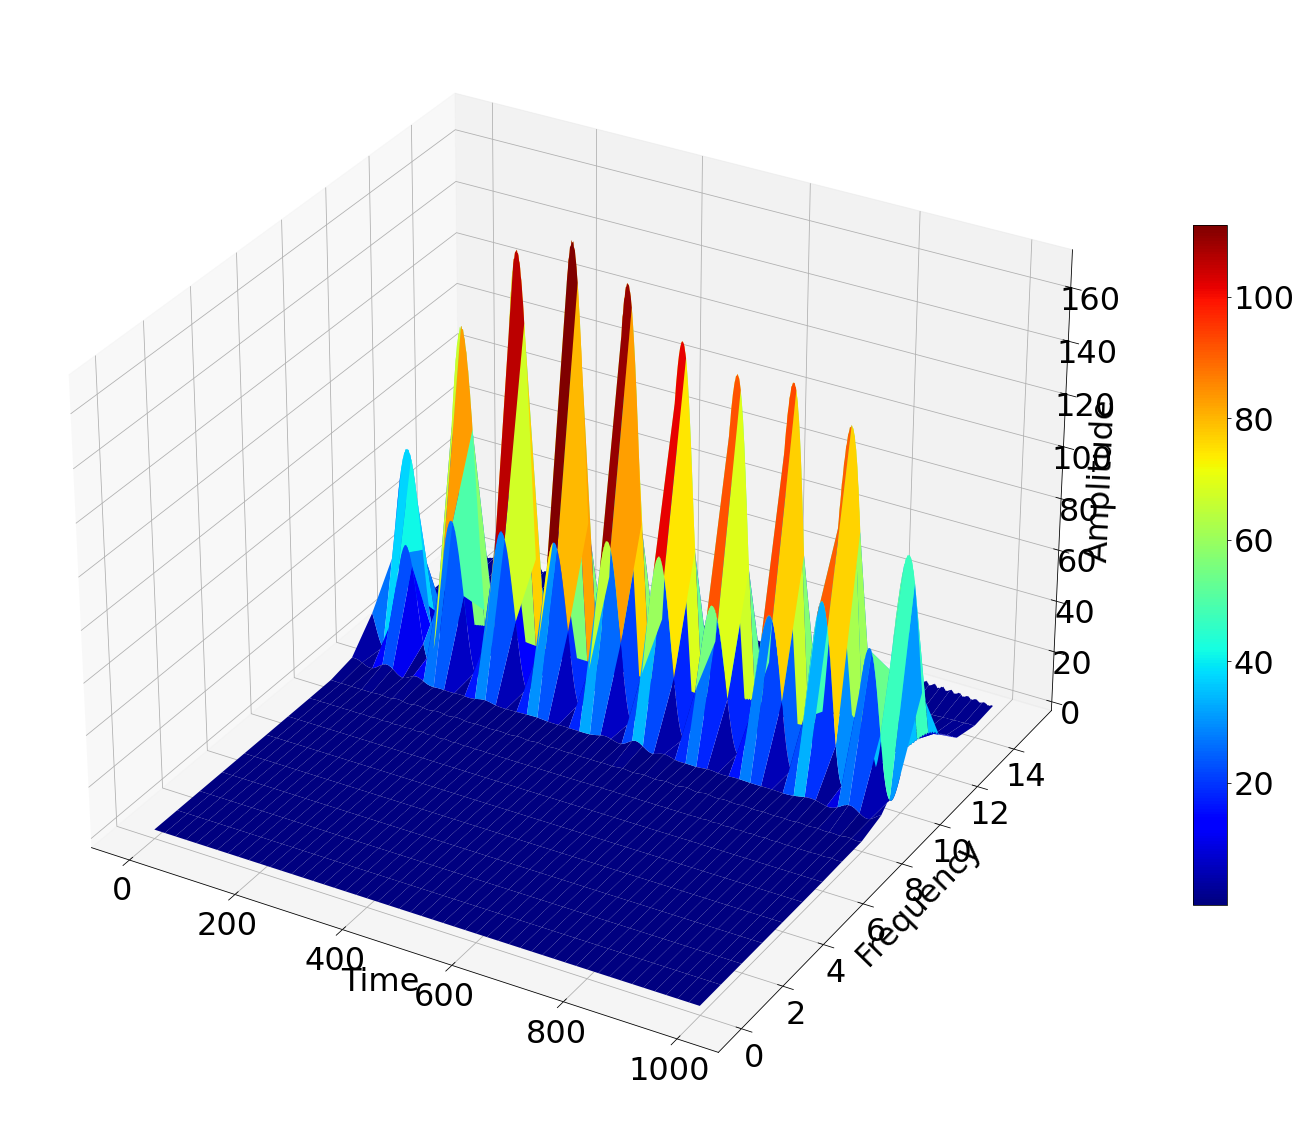


Signal 2
 


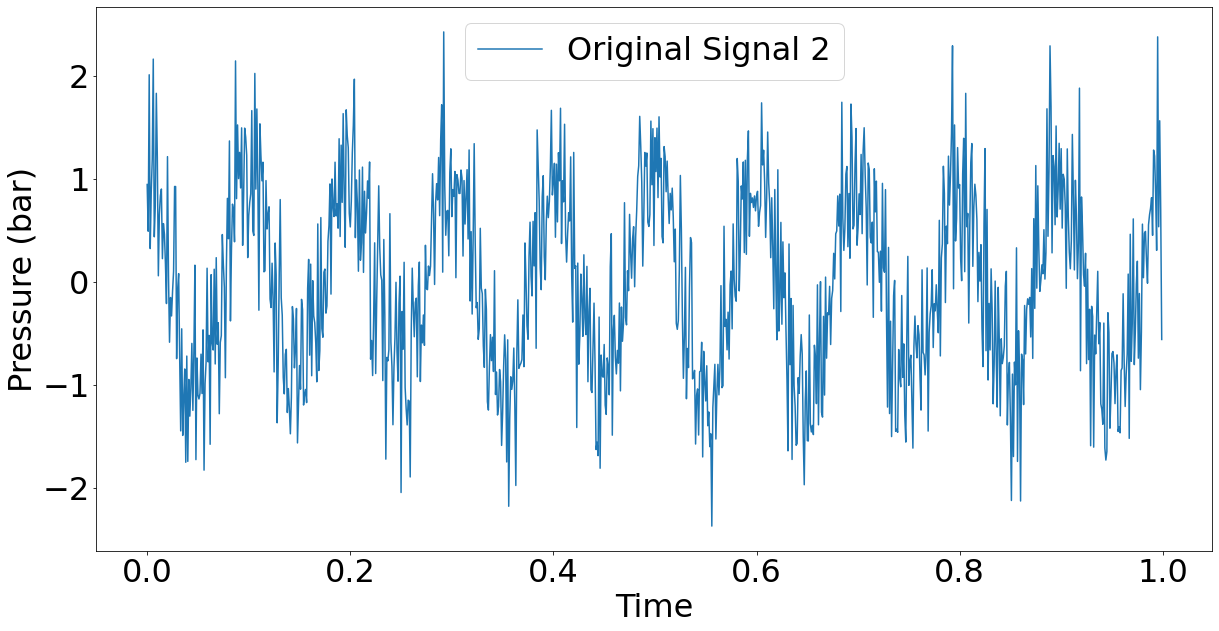

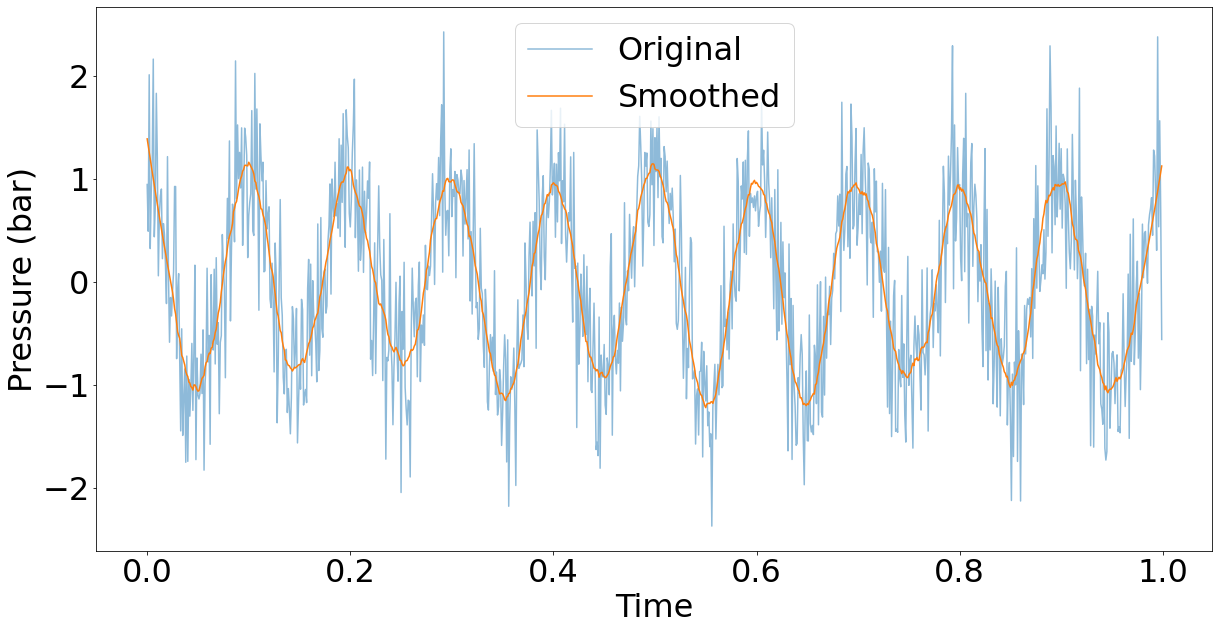

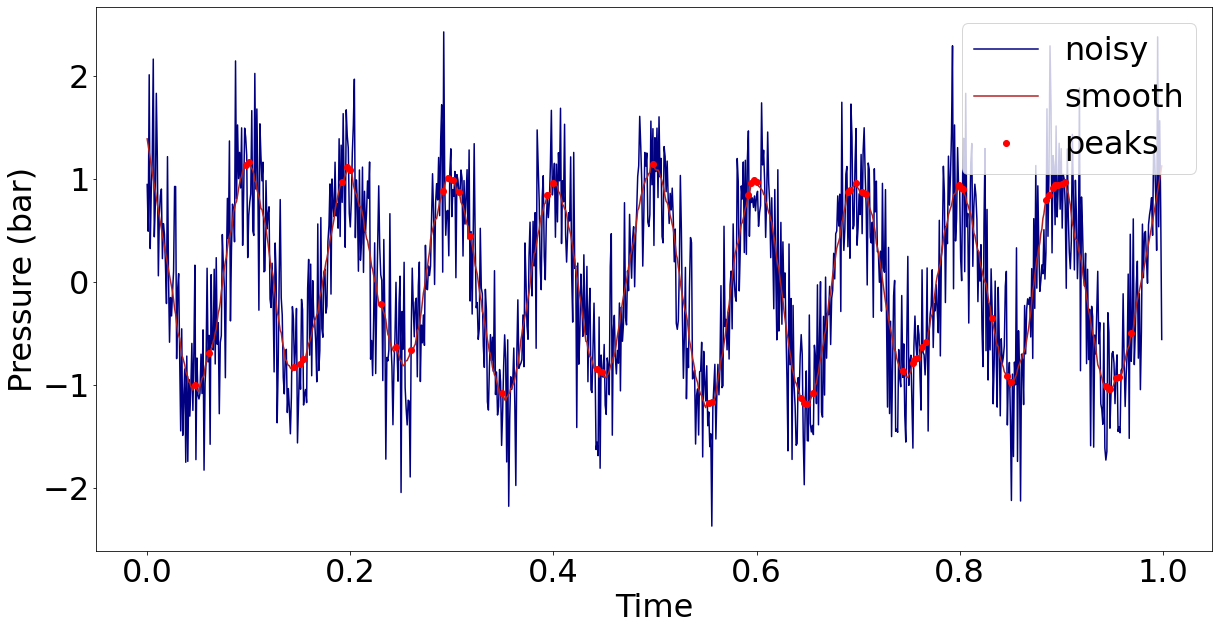

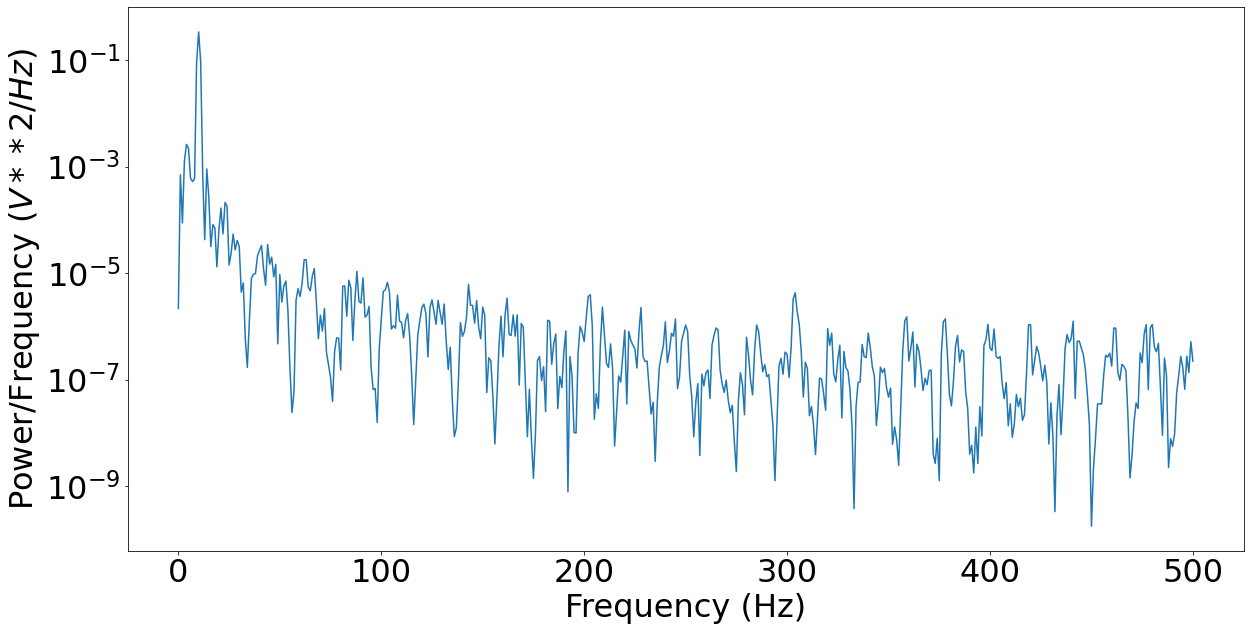

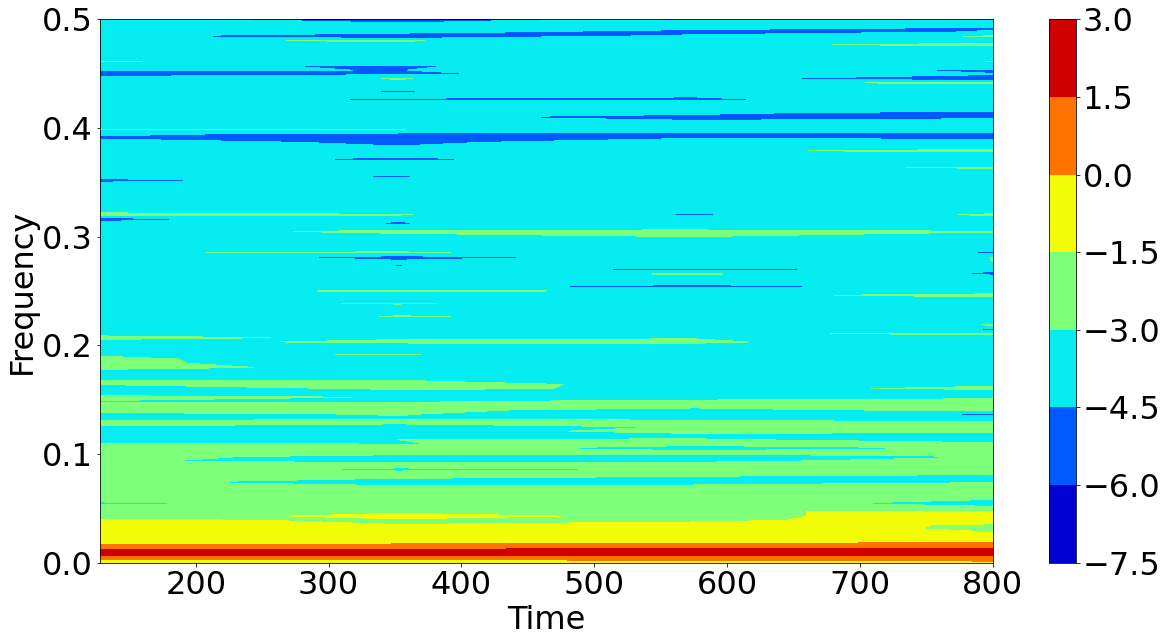

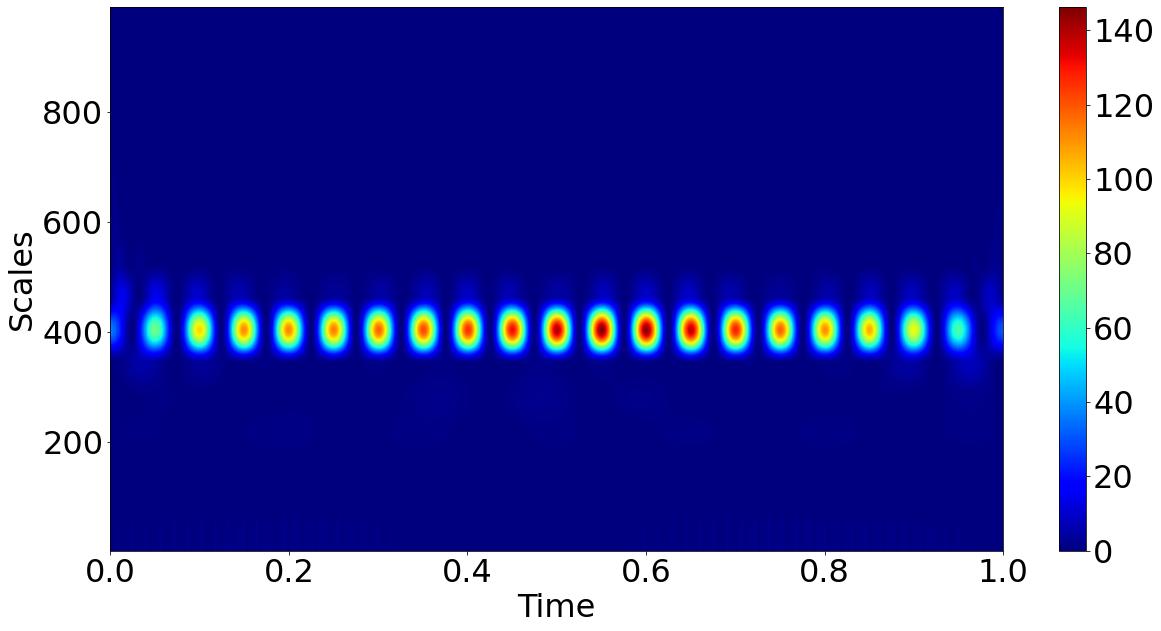

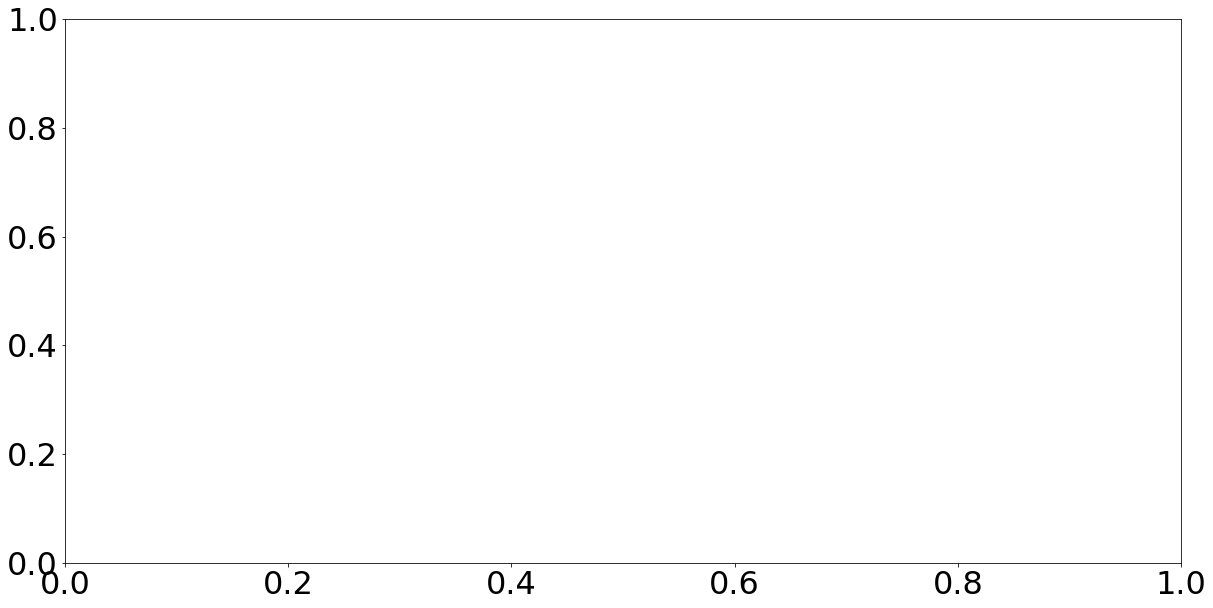

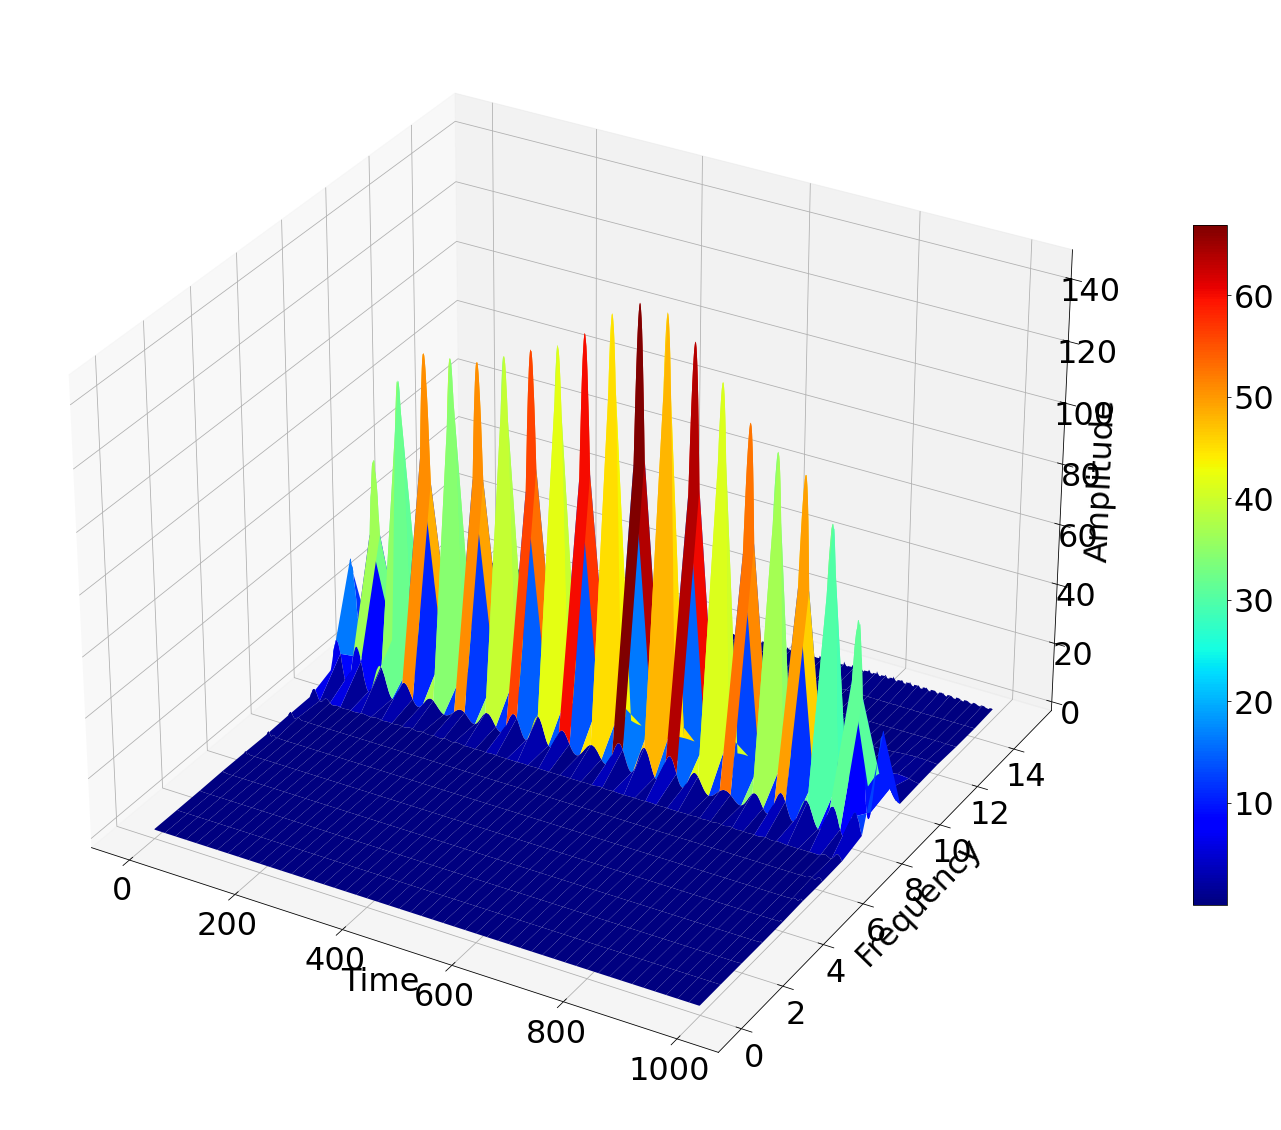


Signal 3
 


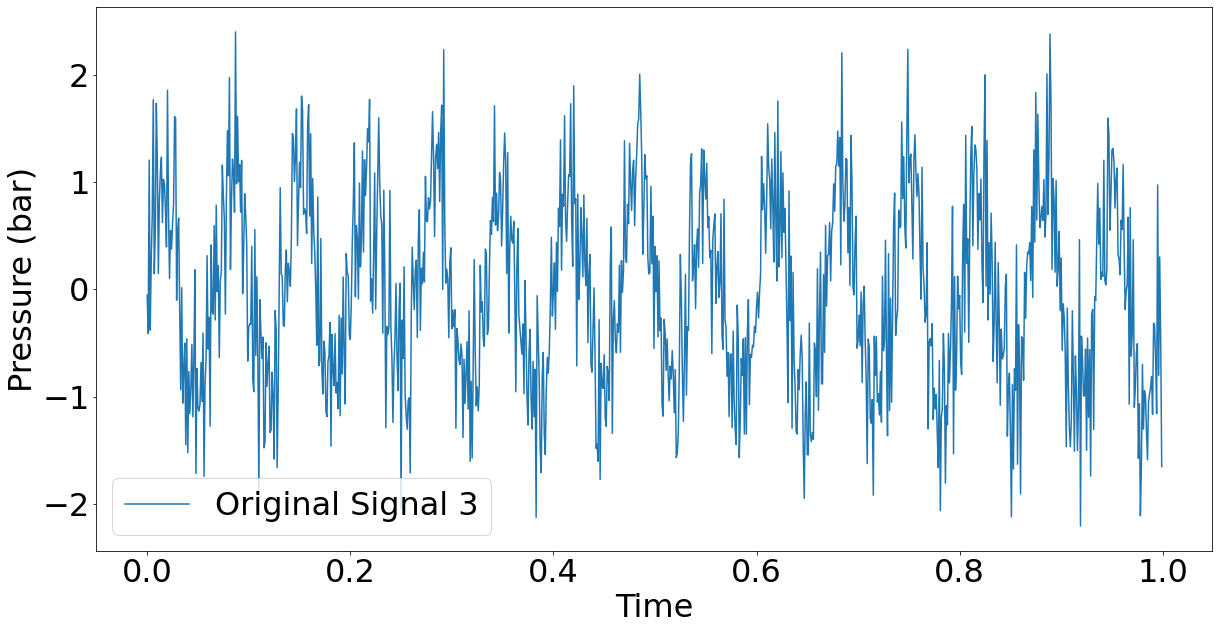

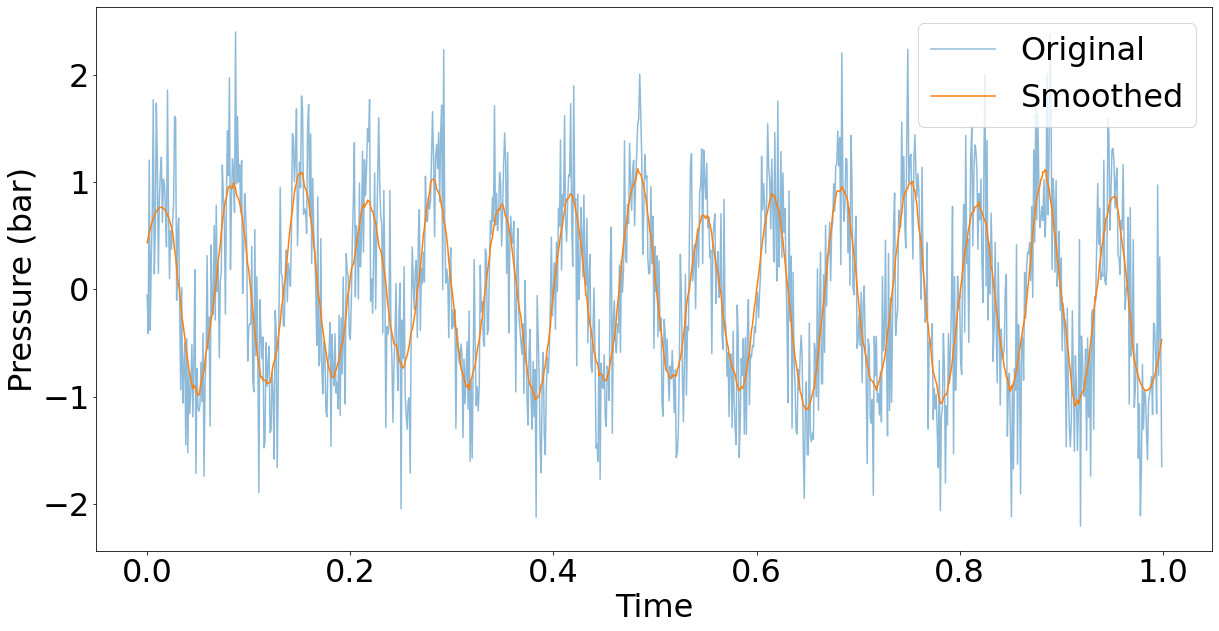

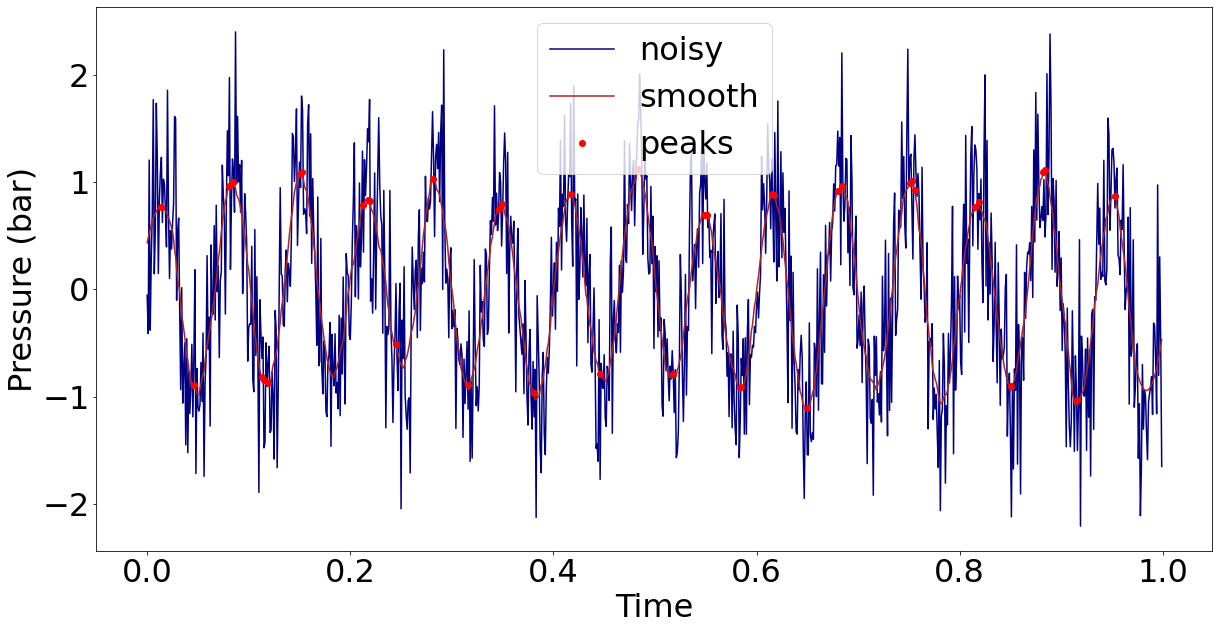

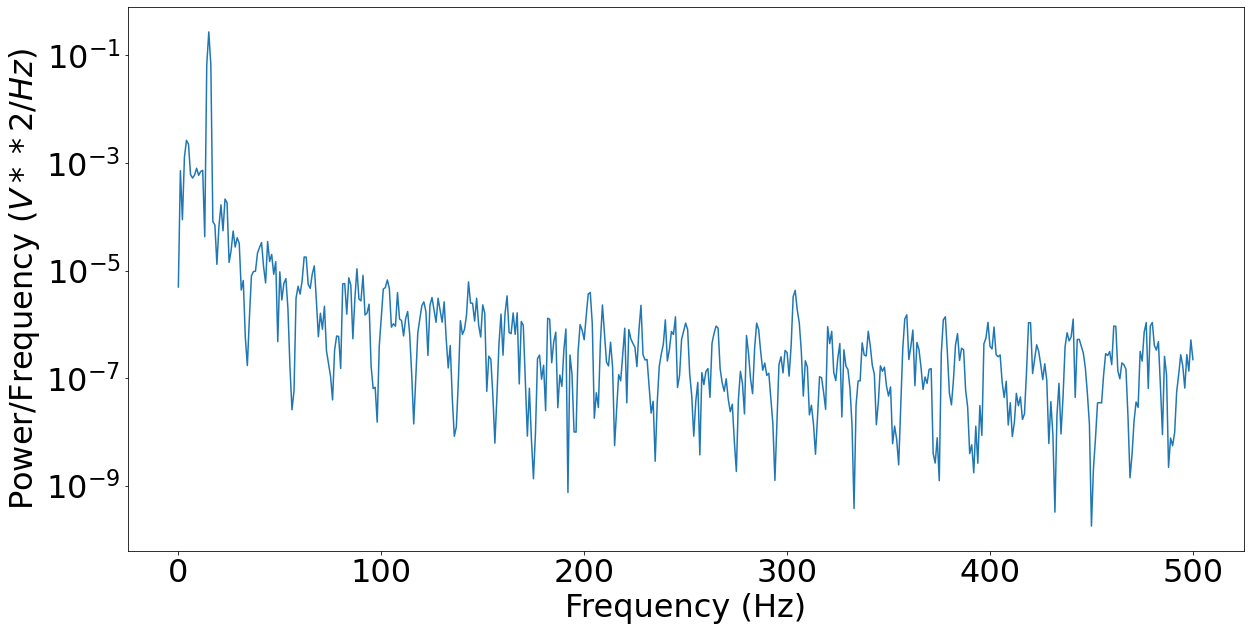

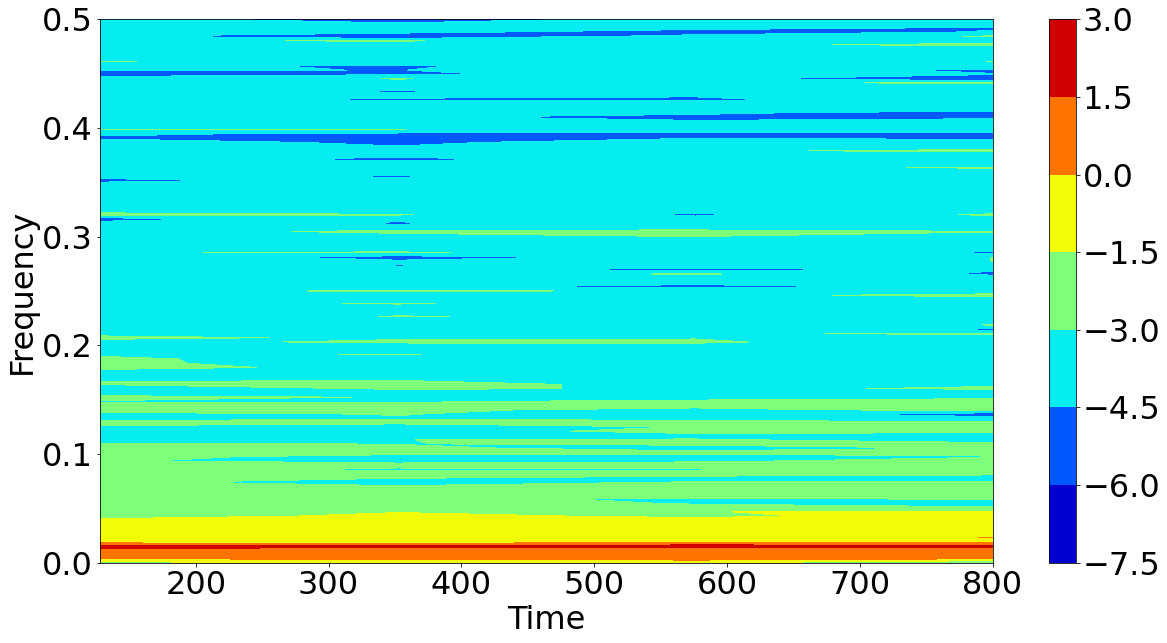

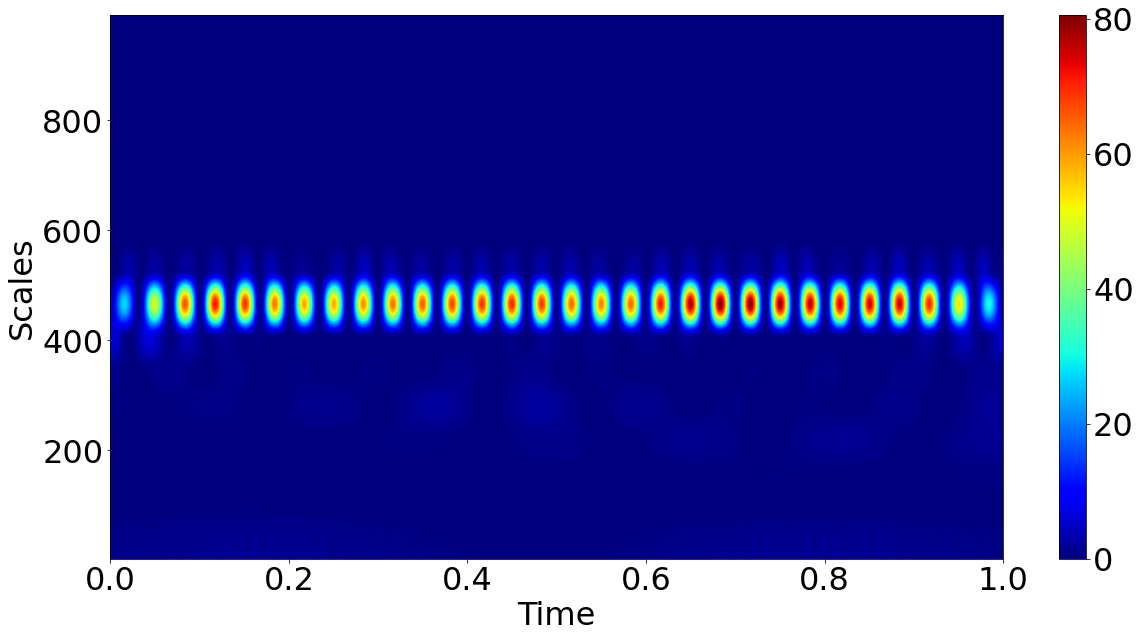

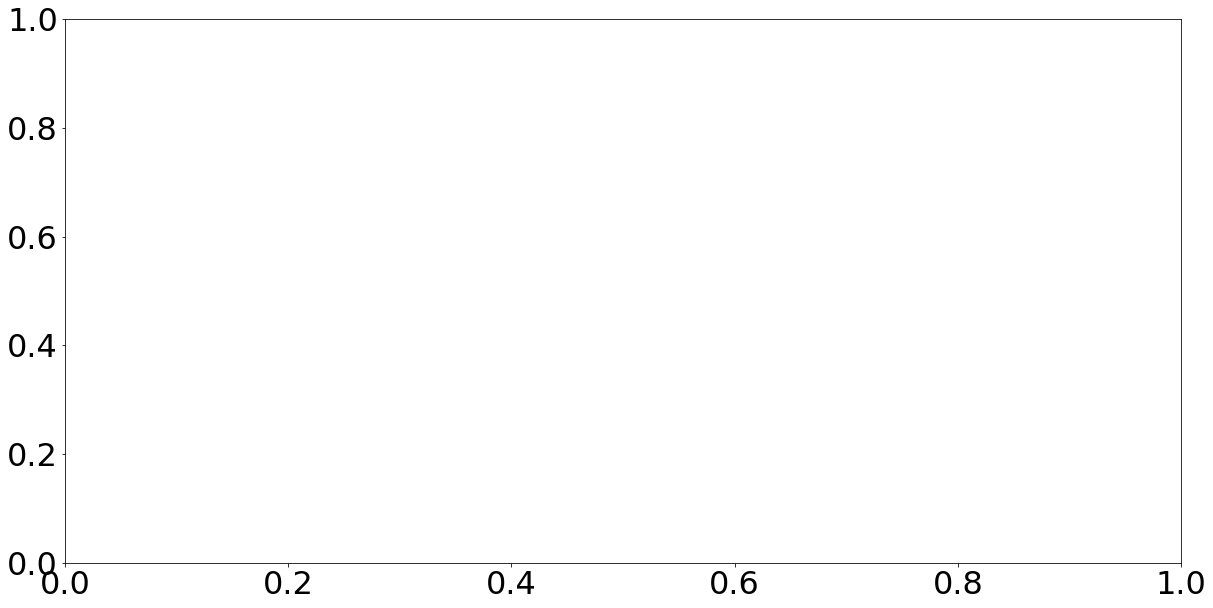

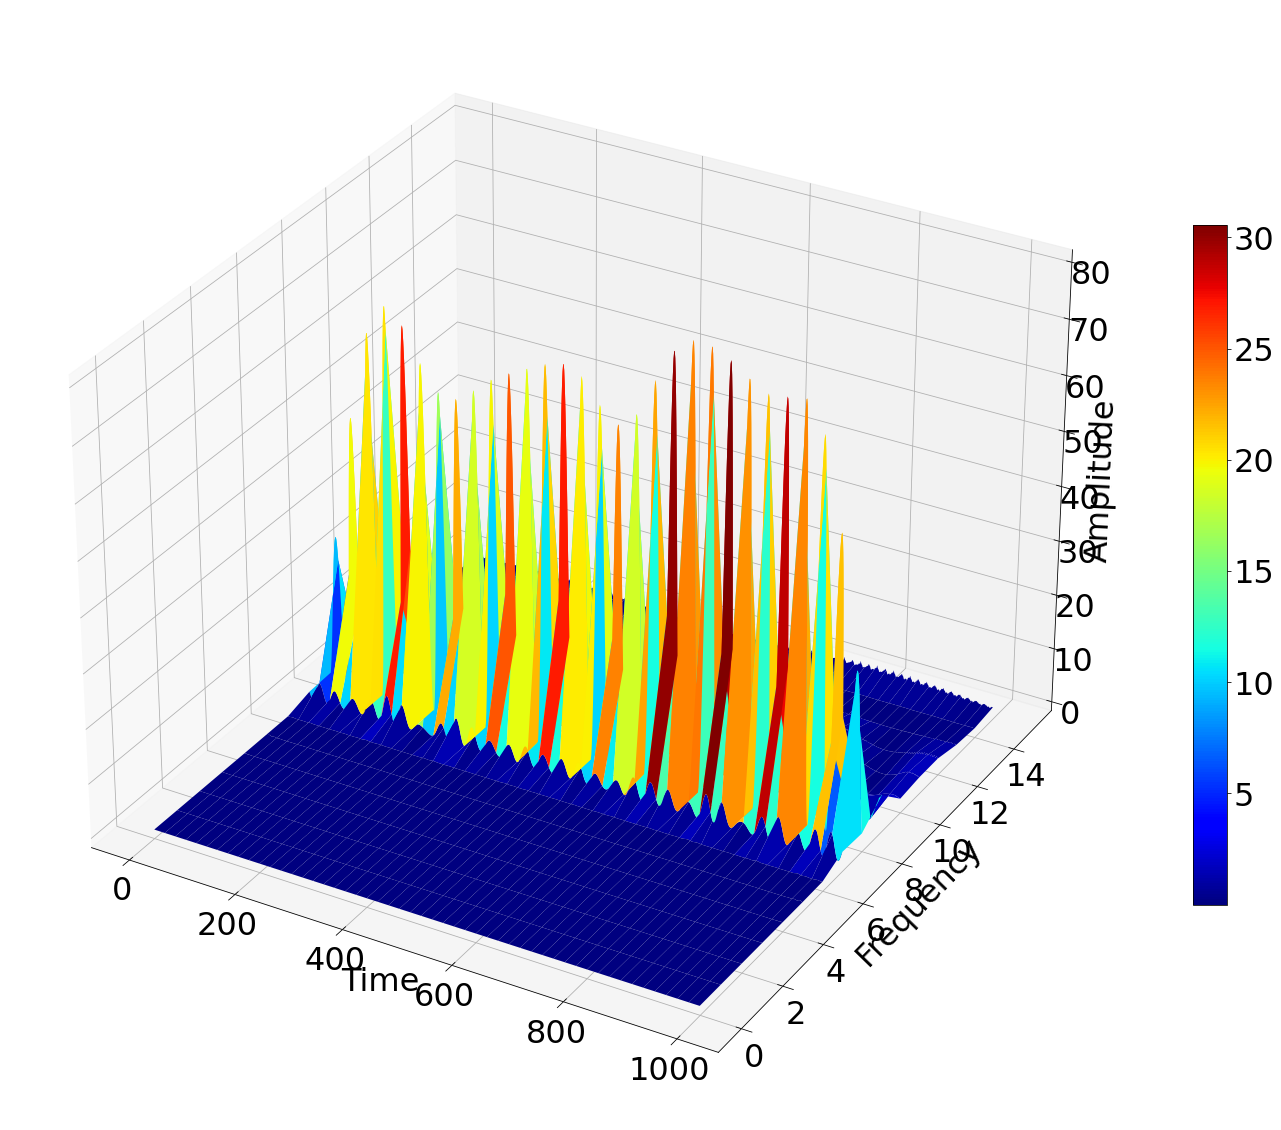

Temporal Features:
+----------+----------------+---------------+-----------+-----------+
|  Signal  | Mean Amplitude | Std Deviation |  Skewness |  Kurtosis |
+----------+----------------+---------------+-----------+-----------+
| Signal 1 |   -0.015587    |    0.739961   | -0.037075 | -1.438444 |
| Signal 2 |   -0.016449    |     0.7162    |  0.01763  | -1.416263 |
| Signal 3 |   -0.015512    |    0.659859   |  0.02617  | -1.429783 |
+----------+----------------+---------------+-----------+-----------+

Spectral Features:
+----------+---------------+-------------------+-----------------+
|  Signal  | Max Frequency | Spectral Centroid | Spectral Spread |
+----------+---------------+-------------------+-----------------+
| Signal 1 |      5.0      |      5.188762     |     5.072165    |
| Signal 2 |      10.0     |     10.065381     |     5.042342    |
| Signal 3 |      15.0     |     14.911503     |     5.727683    |
+----------+---------------+-------------------+-----------------+


In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy import signal as sig
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis
from mpl_toolkits.mplot3d import Axes3D
from prettytable import PrettyTable

plt.rcParams['figure.figsize'] = (20,10)
plt.rcParams.update({'font.size': 32})

def autoscales(N, dt, dj, wf='morlet', p=6):
    """Compute scales as fractional power of two."""
    if wf == 'dog':
        s0 = (dt * np.sqrt(p + 0.5)) / np.pi
    elif wf == 'paul':
        s0 = (dt * ((2 * p) + 1)) / (2 * np.pi)
    elif wf == 'morlet':
        s0 = (dt * (p + np.sqrt(2 + p ** 2))) / (2 * np.pi)
    else:
        raise ValueError('wavelet function not available')

    J = int(np.floor(dj ** -1 * np.log2((N * dt) / s0)))
    s = np.empty(J + 1)

    for i in range(s.shape[0]):
        s[i] = s0 * 2 ** (i * dj)

    return s

def smooth_and_find_peaks(signal):
    smoothed_signal = sig.savgol_filter(signal, 51, 2)
    peaks, _ = find_peaks(smoothed_signal)
    return smoothed_signal, peaks

def plot_signal(ax, t, signal, title):
    ax.plot(t, signal, label=title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Pressure (bar)')
    ax.legend()
def plot_original_and_smoothed(t, ns_signal, sm_signal, title):
#     plt.figure(figsize=(10, 5))
    plt.plot(t, ns_signal, label='Original', alpha=0.5)
    plt.plot(t, sm_signal, label='Smoothed', alpha=1)
#     plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Pressure (bar)')
    plt.legend()
    plt.show()
def plot_smoothed_signal(ax, t, ns_signal, sm_signal, peaks, title):
    ax.plot(t, ns_signal, 'navy', label='noisy')
    ax.plot(t, sm_signal, 'firebrick', label='smooth')
    ax.plot(t[peaks], sm_signal[peaks], 'ro', label ='peaks')
#     ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Pressure (bar)')
    ax.legend()

def plot_psd(ax, freq, psd, title):
    ax.semilogy(freq, psd)
#     ax.set_title(f'Power Spectral Density ({title})')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('PSD [V**2/Hz]'')

def plot_spectrogram(ax, signal, title):
    # Spectrogram
    freq, time, sxx = sig.spectrogram(signal)
    plot = ax.contourf(time, freq, np.log10(sxx), cmap='jet', aspect='auto')
#     ax.set_title(f'Spectrogram of {title}')
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Time')
    plt.colorbar(plot, ax=ax)

def plot_cwt(ax, signal, title):
    # Continuous Wavelet Transform
    wavelet = 'morl'  # Complex Morlet wavelet
    widths = autoscales(len(signal), 1, 0.6)
    cwmatr, freq_cwt = pywt.cwt(signal, widths, wavelet)
    cwtmatr = np.abs(cwmatr)**2
    plot = ax.imshow(cwtmatr, cmap='jet', aspect='auto', extent=[0, 1, min(widths), max(widths)])
#     ax.set_title(f'CWT of {title}')
    ax.set_ylabel('Scales')
    ax.set_xlabel('Time')
    plt.colorbar(plot, ax=ax)

def plot_3d_scalogram(ax, signal, title):
    # Continuous Wavelet Transform
    wavelet = 'morl'  # Complex Morlet wavelet
    widths = autoscales(len(signal), 1, 0.6)
    cwmatr, _ = pywt.cwt(signal, widths, wavelet)
    cwtmatr = np.abs(cwmatr)**2

    # Plot in 3D
    fig = plt.figure(figsize=(25, 25))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(np.arange(cwtmatr.shape[1]), np.arange(cwtmatr.shape[0]))
    sur = ax.plot_surface(X, Y, np.abs(cwtmatr), cmap='jet')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Amplitude')
#     ax.set_title(f'Scalogram in 3D - {title}')
    plt.colorbar(sur, shrink=0.5)
    plt.show()

def calculate_temporal_features(signal, fs):
    mean_amp = np.mean(signal)
    std_dev = np.std(signal)
    skewness = skew(signal)
    kurt = kurtosis(signal)
    return mean_amp, std_dev, skewness, kurt

def calculate_spectral_features(freq, power_spectral_density):
    max_freq = freq[np.argmax(power_spectral_density)]
    total_power = np.sum(power_spectral_density)
    normalized_power = power_spectral_density / total_power
    spectral_centroid = np.sum(normalized_power * freq)
    spectral_spread = np.sqrt(np.sum(normalized_power * (freq - spectral_centroid)**2))
    return max_freq, spectral_centroid, spectral_spread

def analyze_and_plot_signals(ns_signals, sig_names, t, fs=1000):
    num_signals = len(ns_signals)
    # Create tables for numerical values
    columns_temporal = ['Signal', 'Mean Amplitude', 'Std Deviation', 'Skewness', 'Kurtosis']
    columns_spectral = ['Signal', 'Max Frequency', 'Spectral Centroid', 'Spectral Spread']

    table_temporal = PrettyTable(columns_temporal)
    table_spectral = PrettyTable(columns_spectral)
    for i, ns_signal in enumerate(ns_signals, start=1):
        
        print(f'\n{sig_names[i-1]}\n ')
        sm_signal, peaks = smooth_and_find_peaks(ns_signal)

        # Plot original signal
        
        plot_signal(plt.gca(), t, ns_signal, f'Original {sig_names[i-1]}')
        plt.show()

        # Plot smoothed signal superimposed on original signal
        plot_original_and_smoothed(t, ns_signal, sm_signal, f'{sig_names[i-1]} - Original vs Smoothed')
        plt.show()
        

        # Plot smoothed signal with peaks
        plot_smoothed_signal(plt.gca(), t, ns_signal, sm_signal, peaks, f'Smoothed {sig_names[i-1]}')
        plt.show()


        # Plot PSD
        freq_psd, psd = sig.welch(sm_signal, fs, nperseg=1024)
        
        plot_psd(plt.gca(), freq_psd, psd, f'Smoothed {sig_names[i-1]}')
        plt.show()

        # Plot Spectrogram
       
        plot_spectrogram(plt.gca(), sm_signal, f'Smoothed {sig_names[i-1]}')
        plt.show()

        # Plot CWT
       
        plot_cwt(plt.gca(), sm_signal, f'Smoothed {sig_names[i-1]}')
        plt.show()

        # Plot 3D Scalogram
        plot_3d_scalogram(plt.gca(), sm_signal, f'Smoothed {sig_names[i-1]}')

        # Calculate and print Temporal Features
        temporal_features = calculate_temporal_features(sm_signal, fs)
        temporal_features = [round(value, 6) for value in temporal_features]
#         print(f'\nTemporal Features for {sig_names[i-1]}:')
#         print(f'Mean Amplitude: {temporal_features[0]}, Std Deviation: {temporal_features[1]},'
#               f' Skewness: {temporal_features[2]}, Kurtosis: {temporal_features[3]}')

        # Calculate and print Spectral Features
        spectral_features = calculate_spectral_features(freq_psd, psd)
        spectral_features = [round(value, 6) for value in spectral_features]
#         print(f'\nSpectral Features for {sig_names[i-1]}:')
#         print(f'Max Frequency: {spectral_features[0]}, Spectral Centroid: {spectral_features[1]},'
#               f' Spectral Spread: {spectral_features[2]}')
        # Add data to PrettyTables
        table_temporal.add_row([f'{sig_names[i-1]}'] + temporal_features)
        table_spectral.add_row([f'{sig_names[i-1]}'] + spectral_features)
        
    # Print PrettyTables
    print("Temporal Features:")
    print(table_temporal)

    print("\nSpectral Features:")
    print(table_spectral)
# Example usage:
# Assuming t, ns_signal_1, ns_signal_2, ns_signal_3 are defined
# Create different types of signals
t = np.linspace(0, 1, 1000, endpoint=False)
noise_stddev = 0.5  # Standard deviation of the noise
# Generate random noise
noise = np.random.normal(0, noise_stddev, t.shape)
ns_signal_1 = np.sin(2 * np.pi * 5 * t) + noise
ns_signal_2 = np.cos(2 * np.pi * 10 * t) + noise
ns_signal_3 = np.sin(2 * np.pi * 15 * t) + noise

sig_names = ["Signal 1", "Signal 2", "Signal 3"]
analyze_and_plot_signals([ns_signal_1, ns_signal_2, ns_signal_3], sig_names, t)
